## Business Problem: 
The delivery service industry faces the critical challenge of accurately predicting delivery times to ensure efficient operations and meet customer expectations. Inaccurate delivery time estimates can lead to customer dissatisfaction, increased operational costs, and resource mismanagement. Therefore, the primary business problem addressed in this project is the need for a reliable time delivery prediction model that enhances operational efficiency and customer satisfaction.
## Key Challenges:
1. Inconsistent Delivery Times: Variability in delivery times due to factors such as traffic conditions, weather, and order volume makes it challenging to provide accurate delivery estimates.
2. Customer Expectations: With the rise of e-commerce and on-demand delivery services, customers expect precise and timely delivery of their orders. Failure to meet these expectations can result in customer churn and reputational damage.
3. Resource Optimization: Inefficient resource allocation, including delivery personnel and vehicles, can lead to unnecessary costs and delays in order fulfillment.
4. Operational Decision-Making: Lack of insights into the factors influencing delivery times hampers strategic decision-making and process optimization within the delivery service.

Project Objective:
The primary objective of this project is to develop a robust time delivery prediction model that accurately forecasts delivery times based on various influencing factors. By leveraging advanced statistical analysis techniques and machine learning algorithms, the model aims to:
-  Enhance customer satisfaction by providing accurate delivery time estimates and minimizing delays.
- Enable data-driven decision-making by identifying key factors influencing delivery times and their impact on operations.

## IMPORT PACKAGES

In [1]:
from itertools import product
from scipy import stats 
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, f_oneway
from scipy.stats import levene
from scipy.stats import pearsonr 
from scipy.stats import norm 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pandas.api.types import is_numeric_dtype
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, average_precision_score 
from yellowbrick.model_selection import LearningCurve

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
import pingouin as pg
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import optuna
import shap
import warnings
warnings.filterwarnings("ignore")


sns.set_style('darkgrid')
plt.rc('figure', figsize = (18,6))
plt.rc('font', family = 'sans-serif')

## DATA CLEANING AND PREPROCESSING

In [2]:
df1 = pd.read_csv('train.csv')
df_train = df1.copy()
df2 = pd.read_csv('test.csv')
df_test = df2.copy()

### Data Cleaning

In [3]:
df_train['Weatherconditions'].unique()

array(['conditions Sunny', 'conditions Stormy', 'conditions Sandstorms',
       'conditions Cloudy', 'conditions Fog', 'conditions Windy',
       'conditions NaN'], dtype=object)

In [4]:
# drop two redundant columns 'ID' and 'Delivery_person_ID' from df_train and df_test
df_train.drop(columns=['ID','Delivery_person_ID'],inplace=True)
df_test.drop(columns=['ID','Delivery_person_ID'],inplace=True)

# convert datatype to numeric 
df_train['Delivery_person_Age'] = pd.to_numeric(df_train['Delivery_person_Age'], 
                                                errors='coerce')
df_test['Delivery_person_Age'] = pd.to_numeric(df_test['Delivery_person_Age'], 
                                                errors='coerce')

df_train['Delivery_person_Ratings']=pd.to_numeric(df_train['Delivery_person_Ratings'],
                                                  errors='coerce')
df_test['Delivery_person_Ratings']=pd.to_numeric(df_test['Delivery_person_Ratings'],
                                                  errors='coerce')

df_train['multiple_deliveries']=pd.to_numeric(df_train['multiple_deliveries'],
                                              errors='coerce')
df_test['multiple_deliveries']=pd.to_numeric(df_test['multiple_deliveries'],
                                             errors='coerce')

# substitute the entries in the 'Weatherconditions' feature with more succinct values, and then convert any occurrences of 'NaN' represented as strings to null data types.
df_train['Weatherconditions']=df_train['Weatherconditions'].str.replace('conditions ','')\
                                                               .replace('NaN',np.nan)
df_test['Weatherconditions']=df_test['Weatherconditions'].str.replace('conditions ','')\
                                                             .replace('NaN',np.nan)

# transform any occurences of 'NaN' represented as strings into null datatype
df_train['Road_traffic_density']=df_train['Road_traffic_density'].str.strip().replace('NaN',np.nan)
df_test['Road_traffic_density']=df_test['Road_traffic_density'].str.strip().replace('NaN',np.nan)

df_train['Festival']=df_train['Festival'].str.strip().replace('NaN',np.nan)
df_test['Festival']=df_test['Festival'].str.strip().replace('NaN',np.nan)

df_train['City']=df_train['City'].str.strip().replace('NaN',np.nan)
df_test['City']=df_test['City'].str.strip().replace('NaN',np.nan)

# remove leading and trailing whitespace from a value.
df_train['Type_of_order']=df_train['Type_of_order'].str.strip()
df_test['Type_of_order']=df_test['Type_of_order'].str.strip()

df_train['Type_of_vehicle']=df_train['Type_of_vehicle'].str.strip()
df_test['Type_of_vehicle']=df_test['Type_of_vehicle'].str.strip()

# remove unnecessary expression and convert it to float datatype
df_train['Time_taken(min)']=df_train['Time_taken(min)'].str.strip('(min) ').astype(float)


In [5]:
# 'set_frame_style' function sets style and title for dataframe
def set_frame_style(df,caption=''):
  return df.style\
          .set_caption(caption)\
          .set_table_styles([{
            'selector':'caption',
            'props':[('color','White'),('font-size','16px'),
                     ('font-weight','bold'),('text-align','left')]}])
# 'fontdict' function set fontsize and fontweight:
def fontdict(fontsize=20, fontweight='bold'):
  return {'fontsize':fontsize, 'fontweight':fontweight}
# 'check_data' function creates dataframes containing information about a given dataset.

### Data Preprocessing

1. Handle Missing Values

<AxesSubplot: >

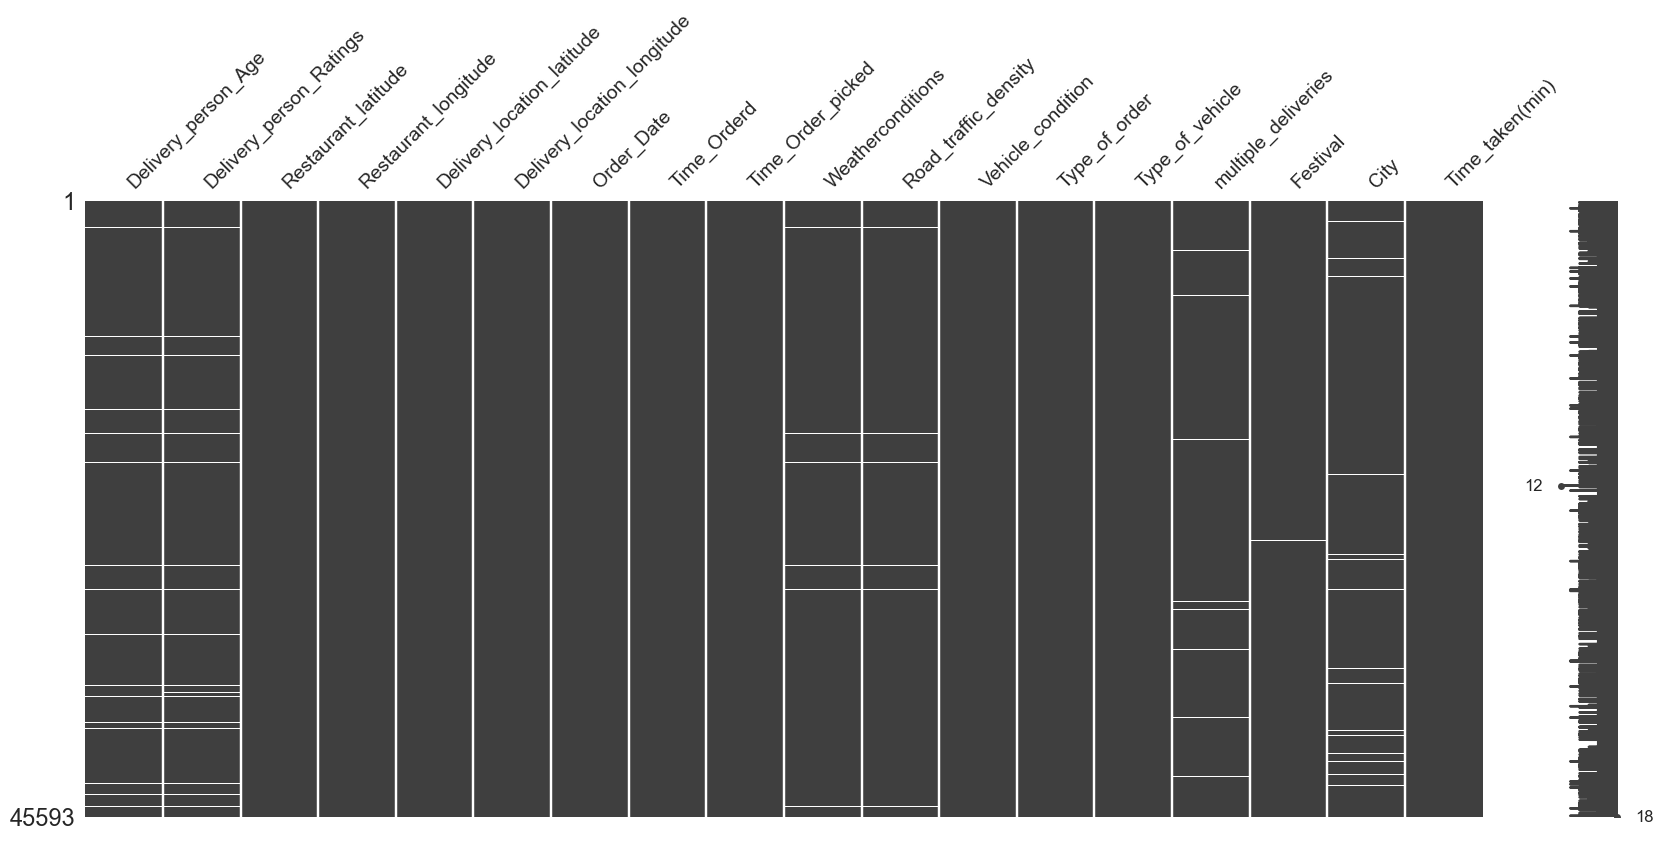

In [6]:
# plot matrix using library missingno (msno)
msno.matrix(df_train,figsize=(20,8),fontsize=14)


We can see patterns here, let's check the percentage of missing values in whole data set, if it is not significantly large, we will just drop data points that have null values

In [7]:
cols=df_train.columns[df_train.isnull().any()].tolist()

#compute the percentages of missing values for each feature
train_null_percentage_col = df_train[cols].isnull().sum()/df_train.size * 100
test_null_percentage_col = df_test[cols].isnull().sum()/df_test.size * 100

#create the dataframes showing percentages of missing values for each feature
df_null_percentage_col = pd.concat([train_null_percentage_col, test_null_percentage_col], 
                                   axis=1,keys=['Training data','Testing data'])

#compute the percentages of missing values of the entire datasets
train_null_percentage=df_train.isnull().sum().sum()/df_train.size * 100
test_null_percentage=df_test.isnull().sum().sum()/df_test.size*100

#create a series showing percentages of missing values of the entire datasets
df_null_percentage=pd.Series([train_null_percentage,test_null_percentage],
                             index=['Training data','Testing data'])\
                              .to_frame('Null Percentage')
display(set_frame_style(df_null_percentage_col,  
                        'NULL percentages for each feature'))
display(set_frame_style(df_null_percentage, 
                        'NULL percentages regarding the entire dataset'))

,Training data,Testing data
Delivery_person_Age,0.225912,0.253376
Delivery_person_Ratings,0.232492,0.261633
Weatherconditions,0.075060,0.081534
Road_traffic_density,0.073232,0.079470
multiple_deliveries,0.120998,0.122818
Festival,0.027782,0.033543
City,0.146221,0.167197


,Null Percentage
Training data,0.901698
Testing data,0.999572


With just 1% of null values in the entire dataset, it is generally reasonable to drop those null values, as they won't significantly affect the overall analysis or modeling process. 

In [8]:
df_train=df_train.dropna()
df_test=df_test.dropna()

In [9]:
# Create bins for a continuous feature 'Delivery_person_Age' and use them as categorical variables in a machine learning model,
# the model will treat each bin as a separate category. 
df_train['Delivery_person_Age_Range']=pd.cut(df_train['Delivery_person_Age'],
                                             bins=[19,25,30,35,40],
                                             labels=['20-25','26-30','31-35','36-40'])
df_test['Delivery_person_Age_Range']=pd.cut(df_test['Delivery_person_Age'],
                                            bins=[19,25,30,35,40],
                                            labels=['20-25','26-30','31-35','36-40'])



Introduce a new feature named 'Distance' computed from the longtitudes and latitudes of restaurants and delivery location to represent the spatial distance between two locations.

In [10]:
# Compute distance between two points using latitude and longitude
def distance(df, lat1, lat2, lon1, lon2):
    lon1_rad = df[lon1].apply(radians)
    lon2_rad = df[lon2].apply(radians)
    lat1_rad = df[lat1].apply(radians)
    lat2_rad = df[lat2].apply(radians)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = dlat.apply(lambda x: sin(x/2)**2) \
        + lat1_rad.apply(cos) \
        * lat2_rad.apply(cos) \
        * dlon.apply(lambda x: sin(x/2) ** 2)

    c = a.apply(lambda x: asin(sqrt(x)))*2
  
    r = 6371  # Radius of Earth in kilometers

    return round(c*r, 2)

# Insert a new column into a DataFrame at the specified position
def insert_column_in_order(df, col, value, new_col=[]):
    if new_col in df.columns:
        return df
    else:
        return df.insert(loc=df.columns.get_loc(col) + 1, 
                         column=new_col, value=value)

# Calculate distance and insert into DataFrames
distance_train = distance(df_train, 'Restaurant_latitude', 'Delivery_location_latitude',
                          'Restaurant_longitude', 'Delivery_location_longitude')
distance_test = distance(df_test, 'Restaurant_latitude', 'Delivery_location_latitude',
                         'Restaurant_longitude', 'Delivery_location_longitude')

insert_column_in_order(df_train, 'Delivery_location_longitude',
                       new_col='Distance (km)', value=distance_train)
insert_column_in_order(df_test, 'Delivery_location_longitude',
                       new_col='Distance (km)', value=distance_test)


In [11]:
# a function converting datetime into day
def convert_to_day(df,col):
  return pd.to_datetime(df[col],format='%d-%m-%Y').dt.strftime('%A')
# a function converting an entry's data type into datetime datatype
def convert_to_datetime_type(df,col):
  return pd.to_datetime(df[col],format='%H:%M:%S')

def convert_to_time_of_day(df,col):
  bins = [0,6,12,18,24]
  labels = ['Night','Morning','Afternoon','Evening']
  return pd.cut(df[col], bins = bins, labels = labels, include_lowest = True)

#create new feature giving information about the day of week
day_train = convert_to_day(df_train,'Order_Date')
day_test = convert_to_day(df_test,'Order_Date')

insert_column_in_order(df_train,'Order_Date',
                       new_col='Weekday',value=day_train)
insert_column_in_order(df_test,'Order_Date',
                       new_col='Weekday',value=day_test)

# We have extracted useful information from the feature 'Order_Date'. 
# In addition, the problem in this project is by no means related to time series.
# Therefore, we can safely drop the redundant column 'Order_Date'
df_train=df_train.drop(columns='Order_Date')

#create new feature which gives information about the time of the day in hour unit
Time_Orderd_Hour_Train = convert_to_datetime_type(df_train,'Time_Orderd').dt.hour
Time_Orderd_Hour_Test = convert_to_datetime_type(df_test,'Time_Orderd').dt.hour

insert_column_in_order(df_train,'Time_Order_picked',
                       new_col='Time_Orderd_Hour',value=Time_Orderd_Hour_Train)
insert_column_in_order(df_test,'Time_Order_picked',
                       new_col='Time_Orderd_Hour',value=Time_Orderd_Hour_Test)

#create new feature giving information about the duration of the delivery in minute unit
Orderd_Picked_Duration_Train = (convert_to_datetime_type(df_train,'Time_Order_picked')\
                                - convert_to_datetime_type(df_train,'Time_Orderd')).dt.seconds/60
Orderd_Picked_Duration_Test = (convert_to_datetime_type(df_test,'Time_Order_picked')\
                               - convert_to_datetime_type(df_test,'Time_Orderd')).dt.seconds/60

#convert the datatype for 'Time_Ordered_Hour': from object datatype to datetime datatype
Time_Of_Day_Train = convert_to_time_of_day(df_train, 'Time_Orderd_Hour')
Time_Of_Day_Test = convert_to_time_of_day(df_test, 'Time_Orderd_Hour' )

insert_column_in_order(df_train,'Time_Orderd_Hour',
                       new_col='Time_Of_Day',value=Time_Of_Day_Train)
insert_column_in_order(df_test,'Time_Orderd_Hour',
                       new_col='Time_Of_Day',value=Time_Of_Day_Test)

insert_column_in_order(df_train,'Time_Order_picked',
                       new_col='Orderd_Picked_Duration_Train',value=Orderd_Picked_Duration_Train)
insert_column_in_order(df_test,'Time_Order_picked',
                       new_col='Orderd_Picked_Duration_Train',value=Orderd_Picked_Duration_Test)

#drop 2 redundant columns as we already captured useful information from them
df_train = df_train.drop(columns = ['Time_Orderd','Time_Order_picked'])

# 'Metropolitian' is basically the same as 'Urban', so we can substitute all of entries having word 'Metropolitian' with 'Urban'.
# The same for 'Jam' and 'High'
df_train['City'] = df_train['City'].replace('Metropolitian','Urban')
df_test['City'] = df_test['City'].replace('Metropolitian','Urban')

df_train['Road_traffic_density'] = df_train['Road_traffic_density'].replace('Jam','High')
df_test['Road_traffic_density'] = df_test['Road_traffic_density'].replace('Jam','High')

The dataset now becomes:


In [12]:
display(set_frame_style(df_train.head(5),
                        caption=f'First 5 Rows of New Training Data'))

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Distance (km),Weekday,Orderd_Picked_Duration_Train,Time_Orderd_Hour,Time_Of_Day,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Delivery_person_Age_Range
0,37.000000,4.900000,22.745049,75.892471,22.765049,75.912471,3.030000,Saturday,15.000000,11,Morning,Sunny,High,2,Snack,motorcycle,0.000000,No,Urban,24.000000,36-40
1,34.000000,4.500000,12.913041,77.683237,13.043041,77.813237,20.180000,Friday,5.000000,19,Evening,Stormy,High,2,Snack,scooter,1.000000,No,Urban,33.000000,31-35
2,23.000000,4.400000,12.914264,77.678400,12.924264,77.688400,1.550000,Saturday,15.000000,8,Morning,Sandstorms,Low,0,Drinks,motorcycle,1.000000,No,Urban,26.000000,20-25
3,38.000000,4.700000,11.003669,76.976494,11.053669,77.026494,7.790000,Tuesday,10.000000,18,Afternoon,Sunny,Medium,0,Buffet,motorcycle,1.000000,No,Urban,21.000000,36-40
4,32.000000,4.600000,12.972793,80.249982,13.012793,80.289982,6.210000,Saturday,15.000000,13,Afternoon,Cloudy,High,1,Snack,scooter,1.000000,No,Urban,30.000000,31-35


In [13]:
print(f"Training dataset's shape: {df_train.shape}")
print(f"Testing dataset's shape: {df_test.shape}")

Training dataset's shape: (41368, 21)
Testing dataset's shape: (10291, 23)


In [14]:
df_train.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Distance (km)', 'Weekday',
       'Orderd_Picked_Duration_Train', 'Time_Orderd_Hour', 'Time_Of_Day',
       'Weatherconditions', 'Road_traffic_density', 'Vehicle_condition',
       'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival',
       'City', 'Time_taken(min)', 'Delivery_person_Age_Range'],
      dtype='object')

Which features are categorical?
- Categorical features are the values nominal, ordinal based. In addition, Categorical features have a limited number of unique values. 
- Categorical: 'Weekday','Orderd_Picked_Duration_Train', 'Time_Of_Day', 'Weatherconditions','Road_traffic_density','Vehicle_condition','Type_of_order','Type_of_vehicle','multiple_deliveries','Festival','City','Delivery_person_Age_Range'

Which features are continuously numerical?
- Continuous: 'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude','Delivery_location_latitude', 'Delivery_location_longitude', 'Distance (km)'

Which is target variable?
- target variable: 'Time_taken(min)'

In [16]:
# assign a target variable column name to a variable for later use
target_col='Time_taken(min)'

cat_cols = ['Weekday','Orderd_Picked_Duration_Train', 'Time_Of_Day', 
            'Weatherconditions','Road_traffic_density','Vehicle_condition',
            'Type_of_order','Type_of_vehicle','multiple_deliveries','Festival',
            'City','Delivery_person_Age_Range']

df_train[cat_cols]= df_train[cat_cols].astype('object')

# assign names of numerical features to num_cols for later use
continuous_cols=df_train.select_dtypes(include='number').columns\
                                                 .drop(target_col).to_list()



In [17]:
def check_data(df, title):
  display(set_frame_style(df.head(), 
                          caption=f'{title}: First 5 rows'))
  display(set_frame_style(df.describe(include='number'),
                          caption=f'{title}: Descriptive Statistic Of Numeric Values'))
  display(set_frame_style(df.describe(include='object'),
                          caption=f'{title}: Descriptive Statistic Of Categorical Values'))
  display(set_frame_style(df.nunique().to_frame('UNIQUE COUNT').transpose(),
                          caption=f'Unique Value Count'))

In [18]:
check_data(df_train, 'TRAIN SET')


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Distance (km),Weekday,Orderd_Picked_Duration_Train,Time_Orderd_Hour,Time_Of_Day,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Delivery_person_Age_Range
0,37.000000,4.900000,22.745049,75.892471,22.765049,75.912471,3.030000,Saturday,15.000000,11,Morning,Sunny,High,2,Snack,motorcycle,0.000000,No,Urban,24.000000,36-40
1,34.000000,4.500000,12.913041,77.683237,13.043041,77.813237,20.180000,Friday,5.000000,19,Evening,Stormy,High,2,Snack,scooter,1.000000,No,Urban,33.000000,31-35
2,23.000000,4.400000,12.914264,77.678400,12.924264,77.688400,1.550000,Saturday,15.000000,8,Morning,Sandstorms,Low,0,Drinks,motorcycle,1.000000,No,Urban,26.000000,20-25
3,38.000000,4.700000,11.003669,76.976494,11.053669,77.026494,7.790000,Tuesday,10.000000,18,Afternoon,Sunny,Medium,0,Buffet,motorcycle,1.000000,No,Urban,21.000000,36-40
4,32.000000,4.600000,12.972793,80.249982,13.012793,80.289982,6.210000,Saturday,15.000000,13,Afternoon,Cloudy,High,1,Snack,scooter,1.000000,No,Urban,30.000000,31-35


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Distance (km),Time_Orderd_Hour,Time_taken(min)
count,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000
mean,29.610013,4.633209,17.254366,70.777471,17.472437,70.841351,26.912076,17.436569,26.553350
std,5.764152,0.315861,7.691357,21.122080,7.337077,21.122283,298.782065,4.793826,9.334363
min,20.000000,2.500000,-30.902872,0.000000,0.010000,0.010000,1.470000,0.000000,10.000000
25%,25.000000,4.500000,12.933298,73.170283,12.989096,73.279083,4.660000,15.000000,19.000000
50%,30.000000,4.700000,18.554382,75.898497,18.636258,76.002471,9.270000,19.000000,26.000000
75%,35.000000,4.900000,22.732225,78.046106,22.785536,78.107097,13.740000,21.000000,33.000000
max,39.000000,5.000000,30.914057,88.433452,31.054057,88.563452,6884.730000,23.000000,54.000000


,Weekday,Orderd_Picked_Duration_Train,Time_Of_Day,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Delivery_person_Age_Range
count,41368,41368.000000,41368,41368,41368,41368,41368,41368,41368.000000,41368,41368,41368
unique,7,3.000000,4,6,3,3,4,3,4.000000,2,2,4
top,Wednesday,5.000000,Evening,Fog,High,0,Meal,motorcycle,1.000000,No,Urban,20-25
freq,6466,13858.000000,21639,7116,17262,13925,10421,24300,26176.000000,40535,41216,12146


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Distance (km),Weekday,Orderd_Picked_Duration_Train,Time_Orderd_Hour,Time_Of_Day,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Delivery_person_Age_Range
UNIQUE COUNT,20,26,487,389,4361,4361,408,7,3,17,4,6,3,3,4,3,4,2,2,45,4


### **Exploration Data Analysis**

#### **Univariate Analysis**
When performing univariate analysis, we are usually interested in analysing one or more variables in dataset individually

Let's plot histograms to see continuous features' distributions 

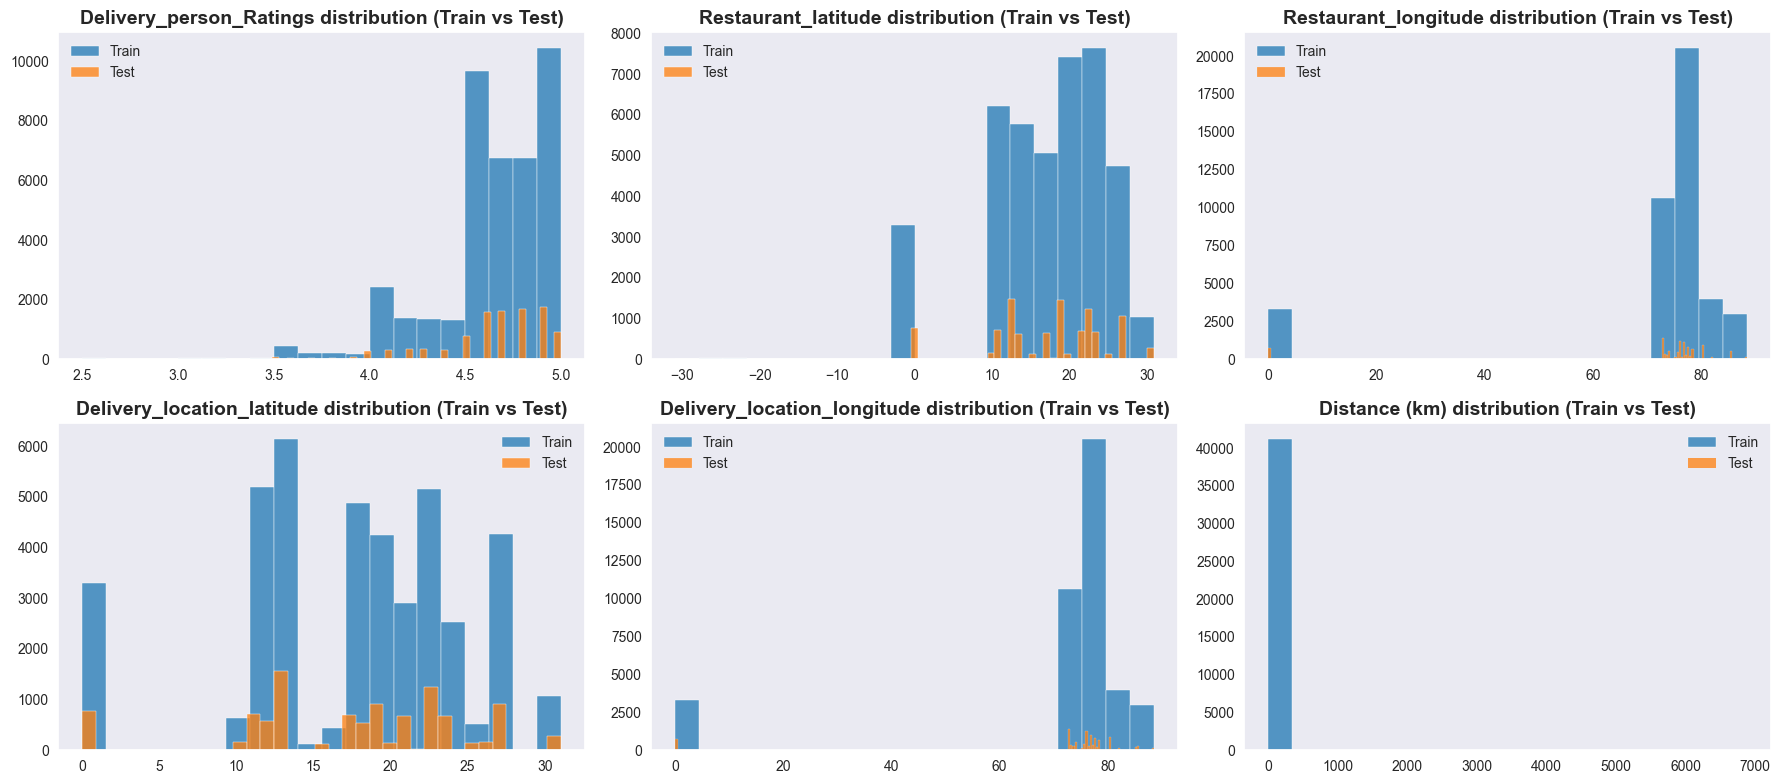

,mean,std,min,max,skewness,median
Delivery_person_Ratings,4.633209,0.315861,2.500000,5.000000,-1.781582,4.700000
Restaurant_latitude,17.254366,7.691357,-30.902872,30.914057,-1.055635,18.554382
Restaurant_longitude,70.777471,21.122080,0.000000,88.433452,-2.955469,75.898497
Delivery_location_latitude,17.472437,7.337077,0.010000,31.054057,-0.703192,18.636258
Delivery_location_longitude,70.841351,21.122283,0.010000,88.563452,-2.955461,76.002471
Distance (km),26.912076,298.782065,1.470000,6884.730000,18.269177,9.270000


In [22]:
# Continuous columns to be plotted
continuous_cols = ['Delivery_person_Ratings', 'Restaurant_latitude', 
                   'Restaurant_longitude', 'Delivery_location_latitude', 
                   'Delivery_location_longitude', 'Distance (km)']

# Set up the subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

# Plot histograms for each continuous column
for i, col_name in enumerate(continuous_cols):
    ax = axes[i]
    sns.histplot(df_train[col_name], color = '#1f77b4',
                  kde=False, ax=ax, label='Train', bins=20)
    sns.histplot(df_test[col_name], color = '#ff7f0e',
                 kde=False, ax=ax, label='Test')
    
    # Set title  
    ax.set_title(f'{col_name} distribution (Train vs Test)', fontdict={'fontsize': 14, 'fontweight': 'bold', 'fontfamily':'sans-serif'})
    ax.legend()
    ax.grid(False)
    ax.set_ylabel(None)
    ax.set_xlabel(None)

# Adjust layout
plt.tight_layout()
plt.show()

# Compute skewness and median for continuous columns in the training set
skewness = df_train[continuous_cols].skew()
median = df_train[continuous_cols].median()

# Create a descriptive statistics table with additional skewness and median
descrip_table = df_train[continuous_cols].describe().transpose()[['mean', 'std', 'min', 'max']]
descrip_table['skewness'] = skewness
descrip_table['median'] = median

# Display the descriptive statistics table with your preferred style
display(set_frame_style(descrip_table))


As depicted above, features 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', and 'Delivery_person_Ratings'are negatively skewed, indicating that the majority of observations are clustered towards higher values, with a tail extending towards the lower end of the scale. Meanwhile, the 'Distance (km)' is positively skewed. It seems that there are a lot of outliers in the dataset. However, i will dive deeper into outlier detection later on

Although Box-Cox (including log) transformations are generally effective for achieving normality, they often introduce complexities in interpretation. At this point, I'm still in the process of exploring the data and determining the statistical methods or models suitable for the dataset. Therefore, I plan to postpone normalization and outlier detections until later stages of the project, when its necessity becomes clearer

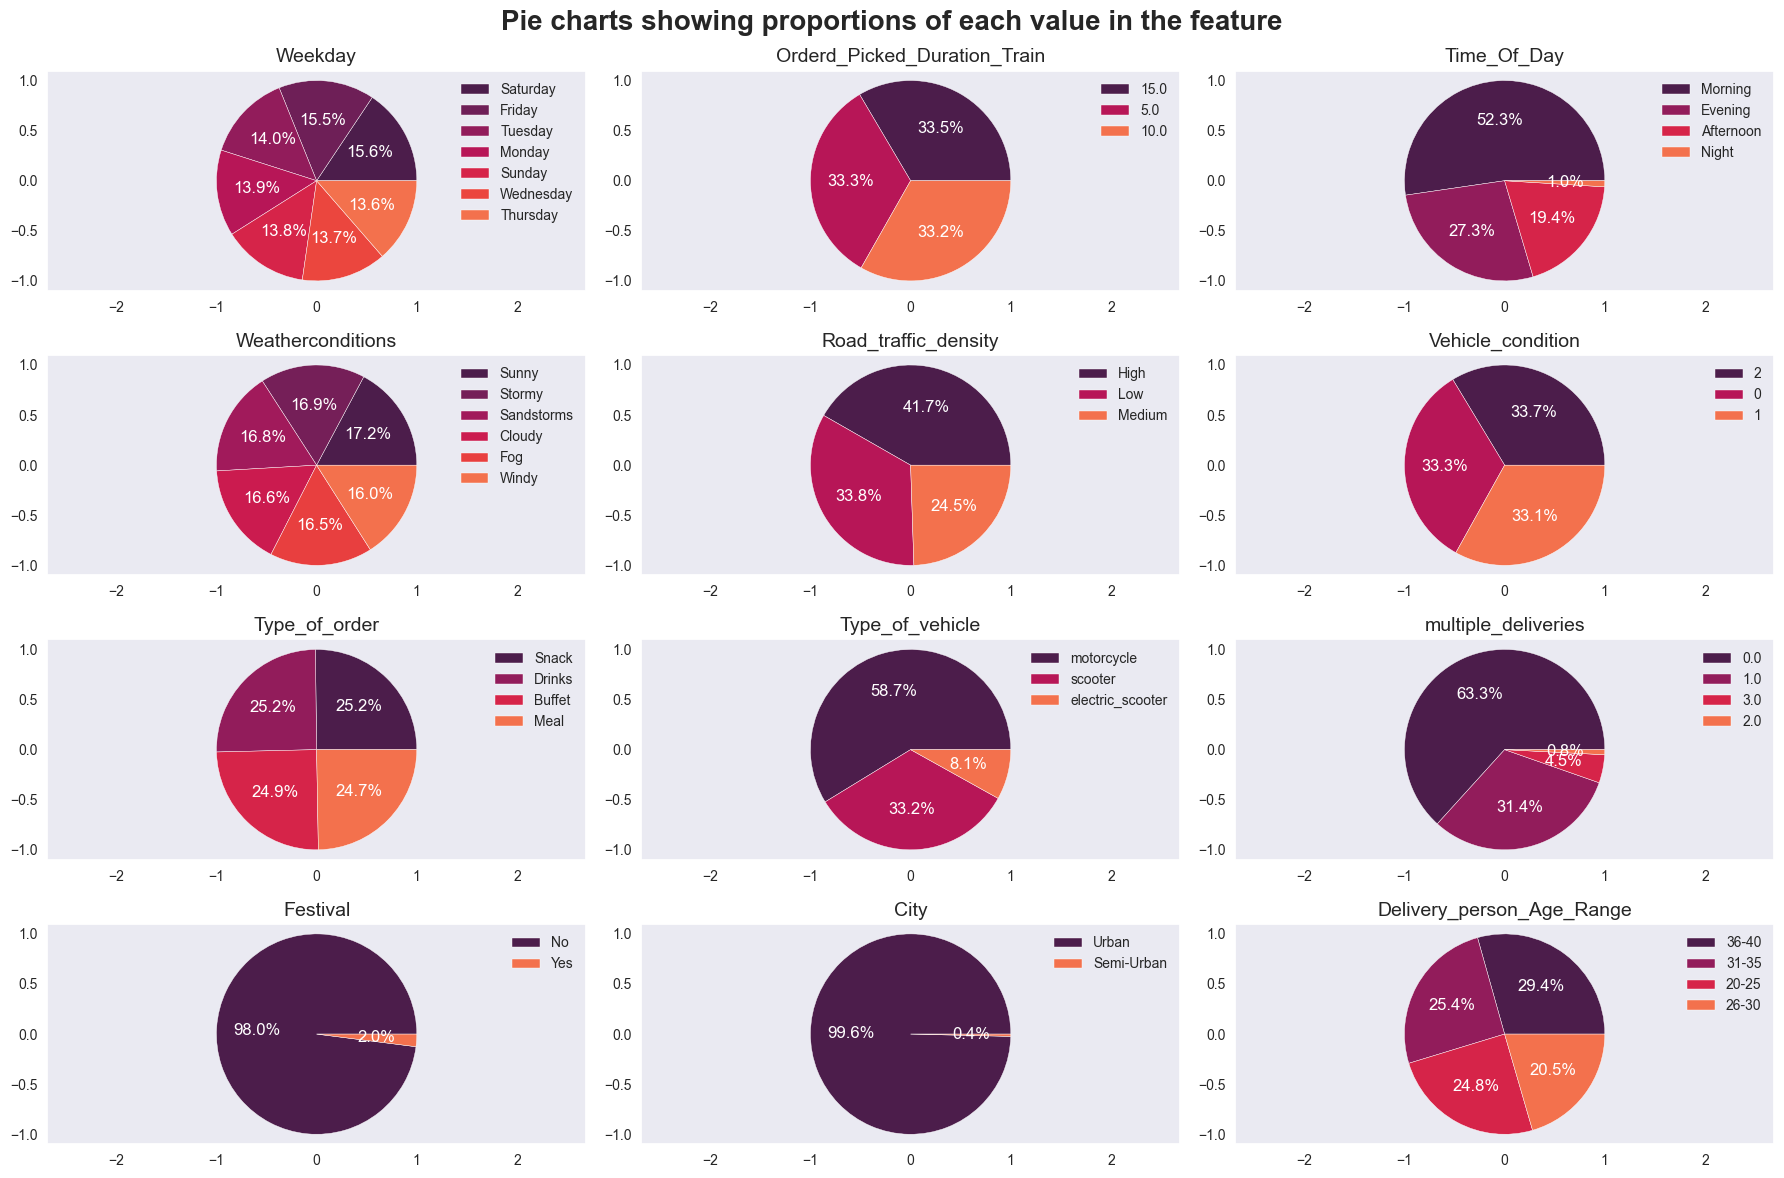

,count,unique,top,freq
Weekday,41368,7,Wednesday,6466
Orderd_Picked_Duration_Train,41368.000000,3.000000,5.000000,13858.000000
Time_Of_Day,41368,4,Evening,21639
Weatherconditions,41368,6,Fog,7116
Road_traffic_density,41368,3,High,17262
Vehicle_condition,41368,3,0,13925
Type_of_order,41368,4,Meal,10421
Type_of_vehicle,41368,3,motorcycle,24300
multiple_deliveries,41368.000000,4.000000,1.000000,26176.000000
Festival,41368,2,No,40535


In [62]:
fig, axes= plt.subplots(nrows=4,ncols=3, figsize=(18,12))
axes= axes.flatten()
for i, col_name in enumerate(cat_cols):
      ax = axes[i]
      colors = plt.get_cmap()(np.linspace( 0.2,0.7, 
                                                 len(df_train[col_name].unique())))
      ax.pie(df_train[col_name].value_counts(), 
             autopct='%1.1f%%', 
             colors = colors, 
             frame=True, 
             textprops={'color': "white"})
      ax.set_title(f'{col_name}', 
                   fontdict=fontdict(14,'medium'))
      ax.grid(False)
      ax.axis('equal')
      ax.legend(df_train[col_name].unique(), loc='best')
fig.suptitle('Pie charts showing proportions of each value in the feature', 
             fontsize=20, 
             fontweight='bold')
plt.tight_layout()
plt.show()

descrip_table = df_train[cat_cols].describe().transpose()

display(set_frame_style(descrip_table))



### **Bivariate analysis**
When performing bivariate analysis, we are interested in how two variables are distributed or related. 

#### **Continous variable vs Continuous variable**

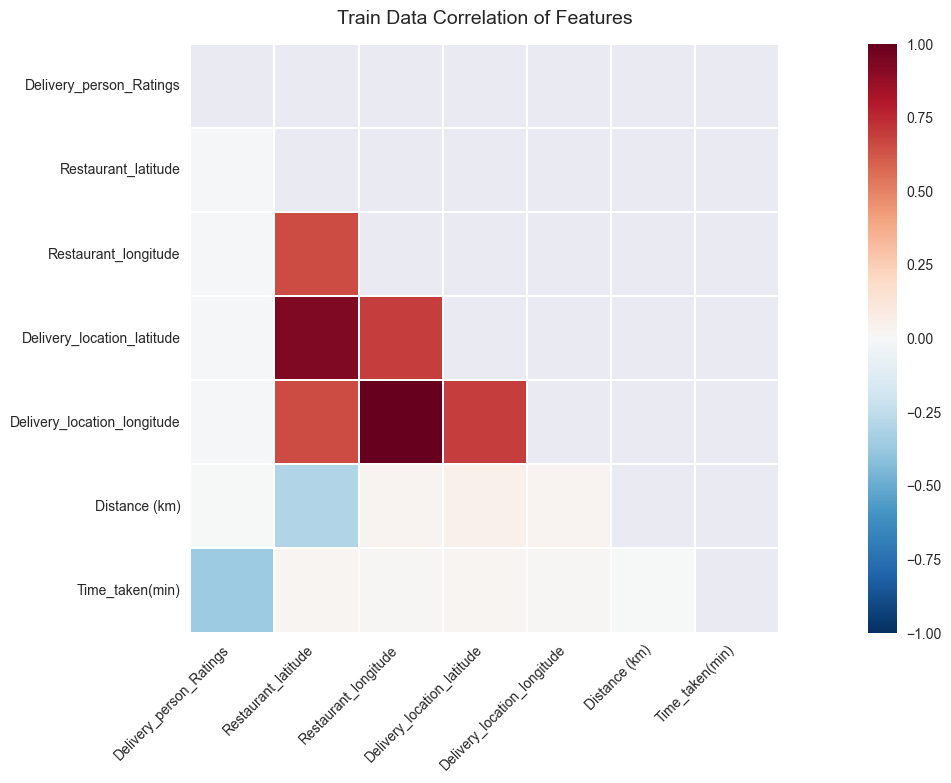

In [34]:
def plot_heatmap(df, title):
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True
    
    # Set the colormap and figure size 
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(18, 8))
    plt.title(f'{title} Correlation of Features', 
              fontdict={'fontsize': 14, 'fontweight': 'regular'}, y=1.02)
    
    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), 
                linewidths=0.1, 
                vmax=1.0, vmin=-1.0, 
                square=True, 
                cmap=colormap, 
                linecolor='white', 
                annot=False, 
                annot_kws={'size': 14, 'weight': 'bold'}, mask=mask)
    
    # Rotate the x-axis tick labels by 45 degrees
    plt.xticks(rotation=45, ha='right')  # 'ha' aligns the labels to the right
    plt.yticks(rotation=0)  # Keep y-ticks horizontal
    
    plt.tight_layout()
    plt.grid(False)
    plt.show()

# Example usage
plot_heatmap(df_train[continuous_cols + [target_col]], 
             title='Train Data')


As shown above, the Restaurant_latitude and Delivery_location_latitude, Restaurant_longitude and Delivery_location_longitude are highly correlated. 

Restaurant_latitude and Delivery_location_latitude, as well as Restaurant_longitude and Delivery_location_longitude, being highly correlated makes sense in the context of food delivery services for several reasons:
- Usually, restaurants choose locations within a certain geographic area to serve. Similarly, delivery services operate within specific regions or zones. Hence, the latitude and logitude coordinates of both the restaurant and delivery locations would naturally be correlated because they operate within the same or overlapping geographic areas
- Restaurants tend to locate themselves where there's a demand for their services (delivery locations)

In spite of the strong correlation between such variables, we can not draw conclusions regarding causual effect of them on each other.


The heatmap above did not reveal any strong associations between the target variable and the continuous features included in the analysis.

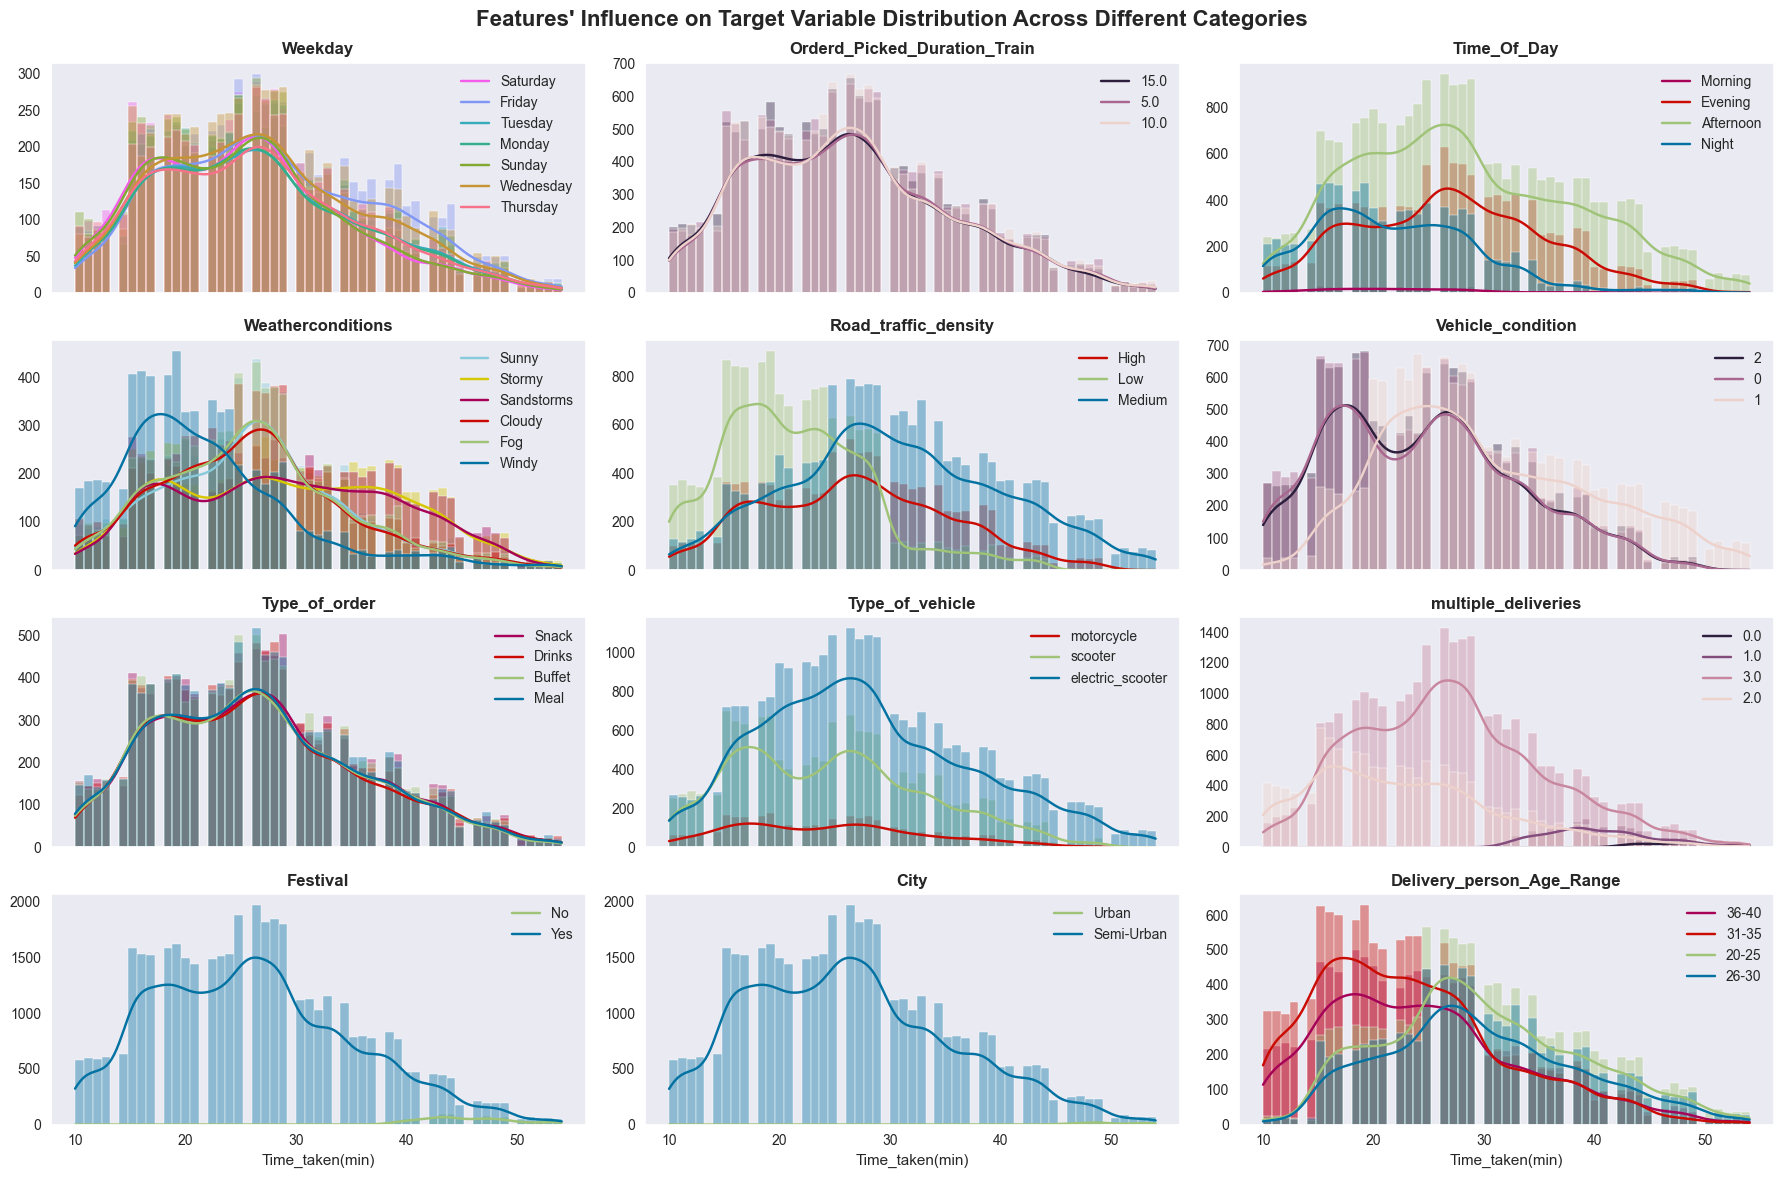

In [36]:
# Define the number of columns and set up the figure and axes for subplots
n_cols = 3
fig, axes = plt.subplots(figsize=(18, 12), 
                         nrows=4, 
                         ncols=n_cols, 
                         sharex=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each categorical column and create a histogram plot
for i, cat_col in enumerate(cat_cols):
    ax = axes[i]
    
    # Plot the histogram with KDE, using the categorical column as the hue
    sns.histplot(data=df_train, 
                 x=target_col, 
                 hue=cat_col, 
                 kde=True, 
                 ax=ax, alpha=0.4)
    
    # Set the title for each subplot
    ax.set_title(f'{cat_col}', fontsize=12, fontweight='bold')
    
    # Disable grid lines
    ax.grid(False)
    
    # Add a legend for the categories
    ax.legend(df_train[cat_col].unique(), loc='best')
    
    # Remove the y-axis label for a cleaner look
    ax.set_ylabel(None)

# Set the overall title for the figure
fig.suptitle("Features' Influence on Target Variable Distribution Across Different Categories", 
             fontweight='bold', fontsize=16)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

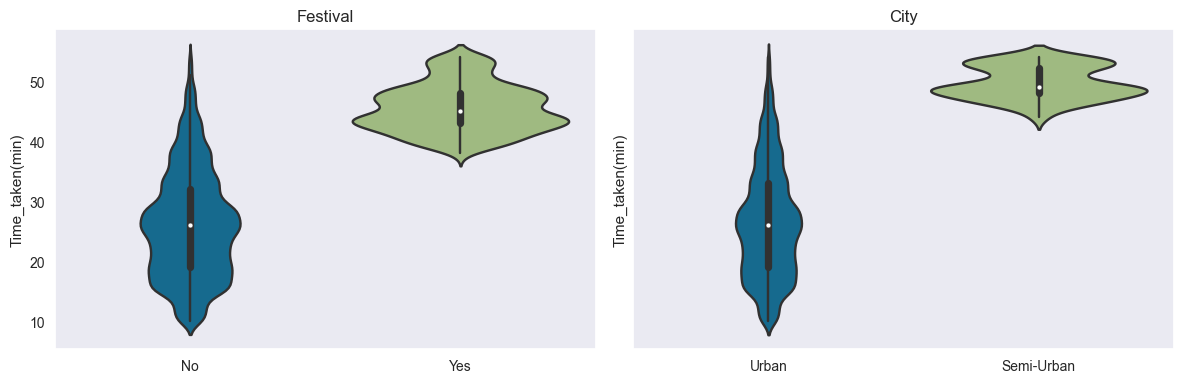

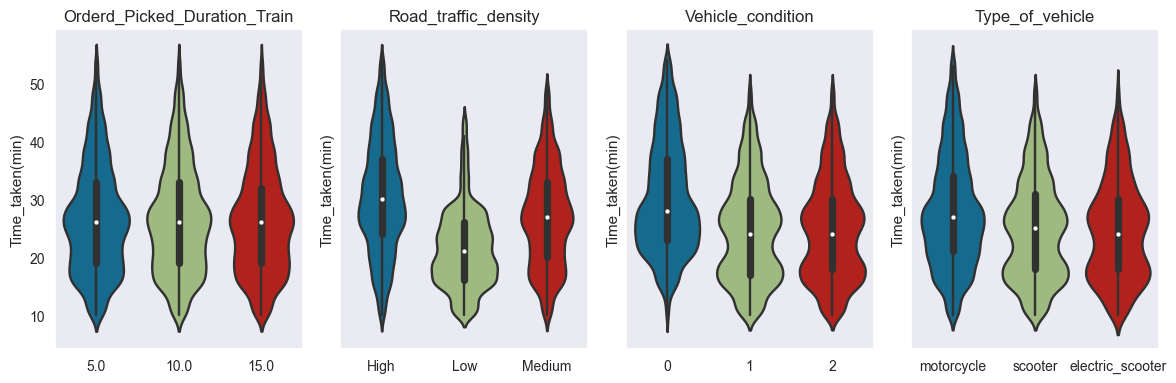

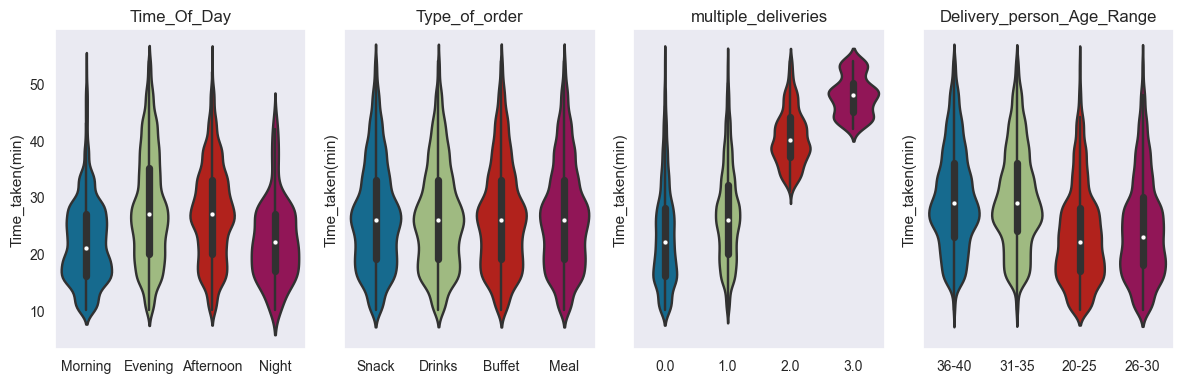

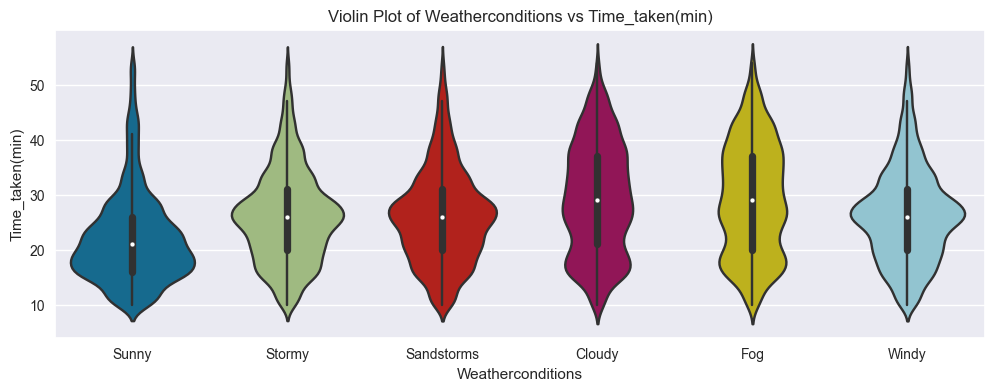

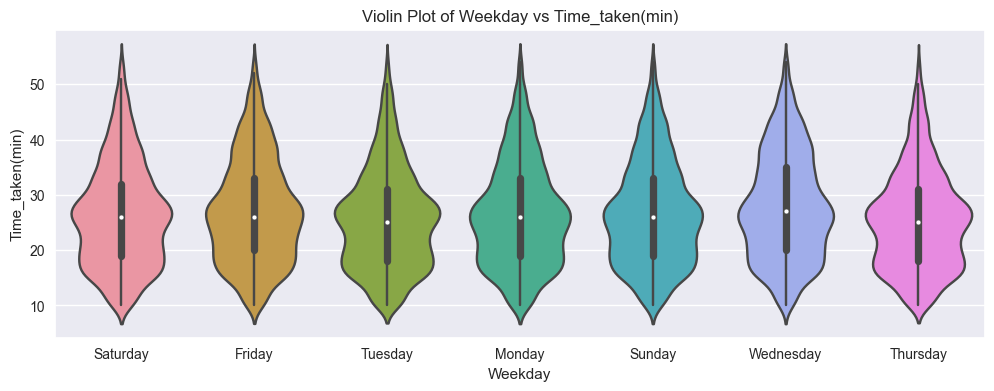

<Figure size 1200x400 with 0 Axes>

In [113]:
def plot_boxplot(nunique):
    # Filter columns from cat_cols where the number of unique values matches 'nunique'
    cols = [col for col in cat_cols if df_train[col].nunique() == nunique]
    n_cols = len(cols)   
    
    # Case when there's only one column to plot
    if n_cols == 1:
        plt.figure(figsize=(12, 4))   
        sns.violinplot(data=df_train,
                       x=cols[0],   
                       y=target_col)   
        plt.title(f'Violin Plot of {cols[0]} vs {target_col}', fontsize=12)   
        plt.show()   
    else:
        # Case when there are multiple columns to plot
        fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=n_cols, sharey=True) 
        axes = axes.flatten()  # Flatten axes array for easy indexing
        
        # Plot each column in its own subplot
        for i, col in enumerate(cols):
            ax = axes[i]   
            sns.violinplot(data=df_train,
                           x=col,   
                           y=target_col,   
                           ax=ax)  
            ax.set_title(f'{col}', fontsize=12)  
            ax.grid(False)   
            ax.set_xlabel(None)  
        
        plt.tight_layout()  
        plt.show()  

# Loop through each unique count of categorical values and generate plots
for nunique in set(df_train[col].nunique() for col in cat_cols):
    plot_boxplot(nunique)

# Add a title to the entire figure containing all subplots
plt.figure(figsize=(12, 4))
plt.suptitle("Violin Plots of Categorical Columns Against Target Column",
             fontweight='bold', fontsize=20)   
plt.show()   


From the two graphs above, we can observe that the distributions of time_taken for deliveries considerably vary among the categories of 'Festival', 'City', 'Delivery_person_Age_Range', 'Road_traffic_density'. However, I will need perform statistical techniques to test whether these differences are statistically significant 

Most statistical testing techniques require the sample to be randomly normally distributed. Therefore, I will now normalize each feature (if necessary) step by step and then conduct statistical testing for each of them

First, let's examine categorical variables that have only two categories, in which we can conduct a t-test to determine if there is any significant difference between the categories. 

1. Festival 

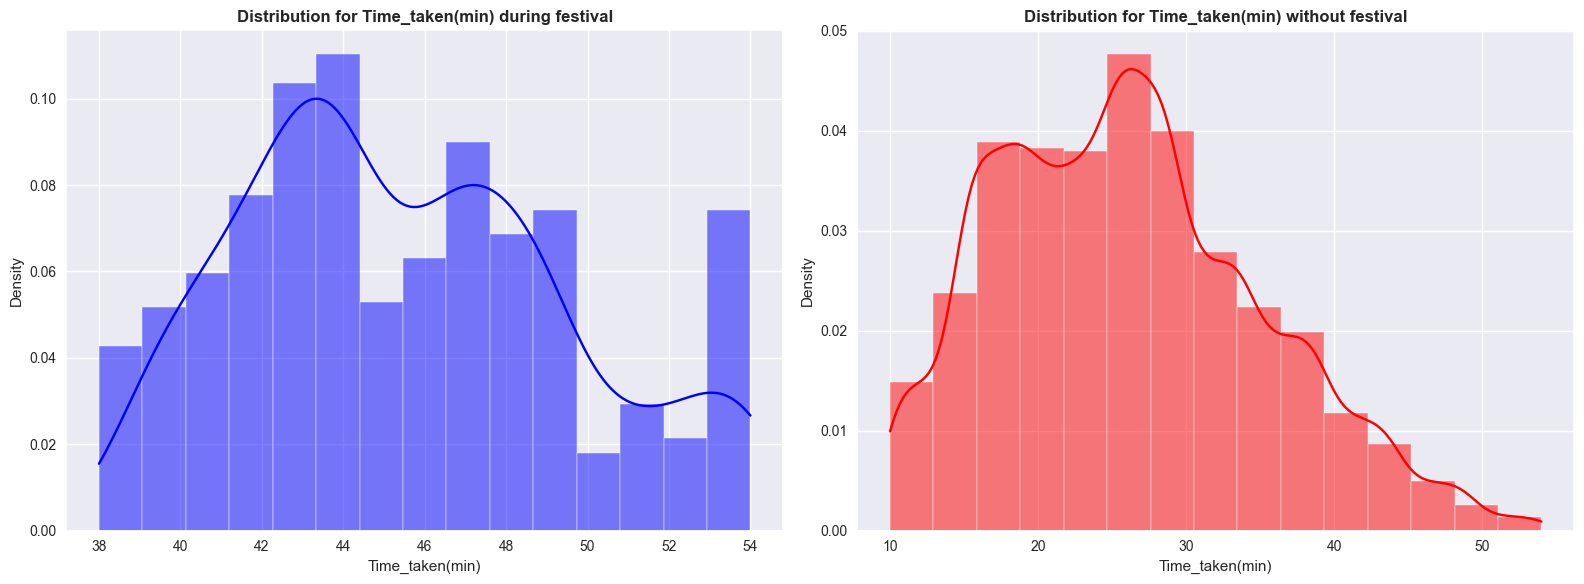

In [134]:
# Separate target column values based on festival status
no_festival = df_train[df_train['Festival'] == 'No'][target_col]
yes_festival = df_train[df_train['Festival'] == 'Yes'][target_col]

fig, (ax1, ax2 )= plt.subplots(1,2,figsize = (16,6),sharey=False)

# Plot distribution for 'Yes' festival
sns.histplot(yes_festival, kde=True, stat="density", 
             bins=15, ax=ax1, color='blue', label='Festival')
ax1.set_title(f'Distribution for {target_col} during festival', 
              fontdict=fontdict(fontsize=12))

# Plot distribution for 'No' festival
sns.histplot(no_festival, kde=True, stat="density", 
             bins=15, ax=ax2, color='red', label='No Festival')
ax2.set_title(f'Distribution for {target_col} without festival', 
              fontdict=fontdict(fontsize=12))

plt.tight_layout()
plt.show()

The two samples appear to be approximately normally distributed. However, if our samples does not follow normal distribution, we can still use t-test as our sample size is larger than 30. The t-test is known to be robust to violations of normality assumption, particularly for large sample sizes. 

Another aspect to take into account is the assumption of equal variance. (The variances of the two populations should be equal). If the data violates this assumption, I will use a modified version of the t-test called Welch's t-test. 

In [137]:

def check_homo(cat):
    # Perform Levene's test
    _, p_value = levene(*cat)
    alpha = 0.05
    
    # Check if the p-value is less than the significance level
    if p_value < alpha:
        print(f'p-value: {p_value } < 0.05\nVariances are not equal')
    else:
        print(f'p-value: {p_value } >= 0.05\nVariances are equal')

# Check homogeneity of variances for the given groups
check_homo([no_festival, yes_festival])

p-value: 2.9898345955707475e-101 < 0.05
Variances are not equal


Because Variances are not equal, i will implement Welch's t-test on the two data samples

In [138]:
def t_test(cat1, cat2):
  """ Perform a two-sample t-test assuming equal variances."""

  _, p_value = ttest_ind(cat1, cat2, equal_var=True)
  alpha = 0.05
   # Check if p-value is less than alpha
  if p_value < alpha:
    print(f'p-value: {p_value } < 0.05\n'
              'Reject the null hypothesis\n'
              'At the 5% significance level, there is enough evidence to conclude that\n'
              'there is a significant difference between the means of the two samples.')
  else:  
    print(f'p-value: {p_value } >= 0.05\n'
              'Fail to reject the null hypothesis\n'
              'At the 5% significance level, there is not enough evidence to conclude that\n'
              'there is a significant difference between the means of the two samples.')
    
def welch_t_test(cat1, cat2):
  """ Perform a two-sample t-test assuming unequal variances (Welch's t-test)."""

  _, p_value = ttest_ind(cat1, cat2, equal_var=False)
  alpha = 0.05
  
  if p_value < alpha:
    print(f'p-value: {p_value } < 0.05\n'
              'Reject the null hypothesis\n'
              'At the 5% significance level, there is enough evidence to conclude that\n'
              'there is a significant difference between the means of the two samples.')
  else:  
    print(f'p-value: {p_value } >= 0.05\n'
              'Fail to reject the null hypothesis\n'
              'At the 5% significance level, there is not enough evidence to conclude that\n'
              'there is a significant difference between the means of the two samples.')

In [139]:
welch_t_test(no_festival, yes_festival)

p-value: 0.0 < 0.05
Reject the null hypothesis
At the 5% significance level, there is enough evidence to conclude that
there is a significant difference between the means of the two samples.


2. City

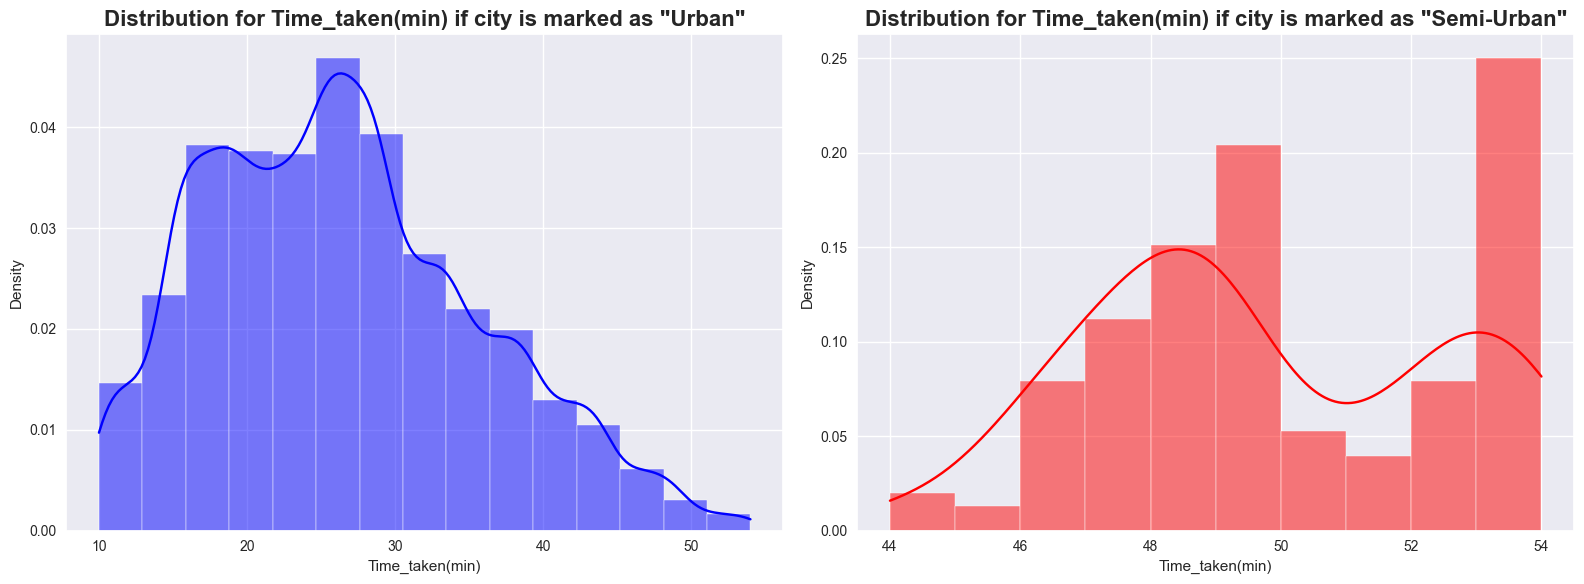

In [133]:
# Extract target column values for different city types
urban = df_train[df_train['City'] == 'Urban'][target_col]
semi_urban = df_train[df_train['City'] == 'Semi-Urban'][target_col]

# Create a figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot histogram for 'Urban' city type with density estimation
sns.histplot(urban, ax=ax1, color='Blue', kde=True, stat="density", bins=15)
# Plot histogram for 'Semi-Urban' city type with density estimation
sns.histplot(semi_urban, ax=ax2, color='Red', kde=True, stat="density", bins=10)

# Set titles for the histograms
ax1.set_title(f'Distribution for {target_col} if city is marked as "Urban"', fontdict=fontdict(16))
ax2.set_title(f'Distribution for {target_col} if city is marked as "Semi-Urban"', fontdict=fontdict(16))

# Adjust layout to prevent overlap
plt.tight_layout()


In [140]:
check_homo([urban, semi_urban])

p-value: 1.1801207128842562e-31 < 0.05
Variances are not equal


In [141]:
welch_t_test(urban, semi_urban)

p-value: 5.086871662228885e-151 < 0.05
Reject the null hypothesis
At the 5% significance level, there is enough evidence to conclude that
there is a significant difference between the means of the two samples.


Now let's move on categorical features that have more than 2 categories. 

For such categorical features, I will perform one-way analysis of variance test (one-way anova). For this test, the samples must be selected from a normal or appoximately normal population

Let's examine the distribution using boxplot

**1. Weekday**

In [144]:
def plot_violin( x, df=df_train, target_col=target_col ):
  sns.violinplot(data=df, x=x, y=target_col )


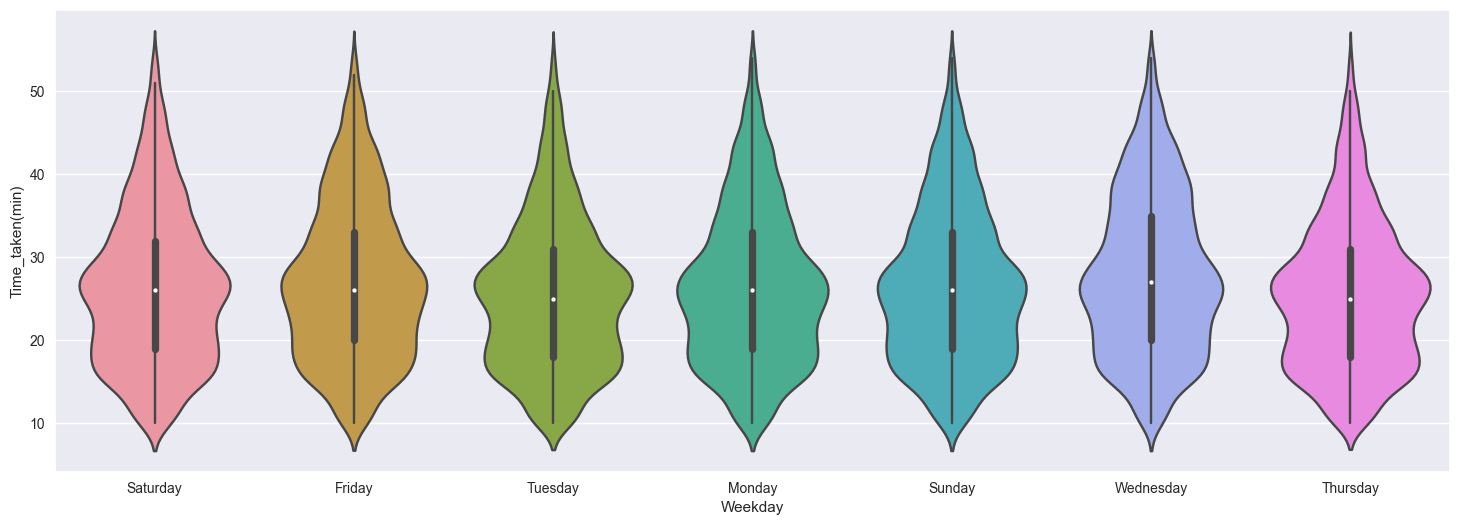

In [145]:
plot_violin('Weekday')

As shown above, the data does not appear to be normally distributed. Now, I will use boxcox transformation to normalize the data

In [146]:
def log_transform(cat_col, target_col=target_col, df=df_train):
    """
    Apply a logarithmic transformation to the target column, grouped by a categorical column."""
    transformed_data = pd.DataFrame()  # Create an empty DataFrame for transformed data

    # Apply logarithmic transformation to the target column grouped by the categorical column
    transformed_data[target_col] = df.groupby(cat_col)[target_col].apply(lambda x: np.log(x))
    
    # Explode lists into separate rows (if any)
    transformed_data = transformed_data.explode(target_col)
    
    # Reset index to make the DataFrame tidy
    transformed_data.reset_index(inplace=True)
    
    # Ensure the transformed column is of type float
    transformed_data[target_col] = transformed_data[target_col].astype('float')
    
    return transformed_data



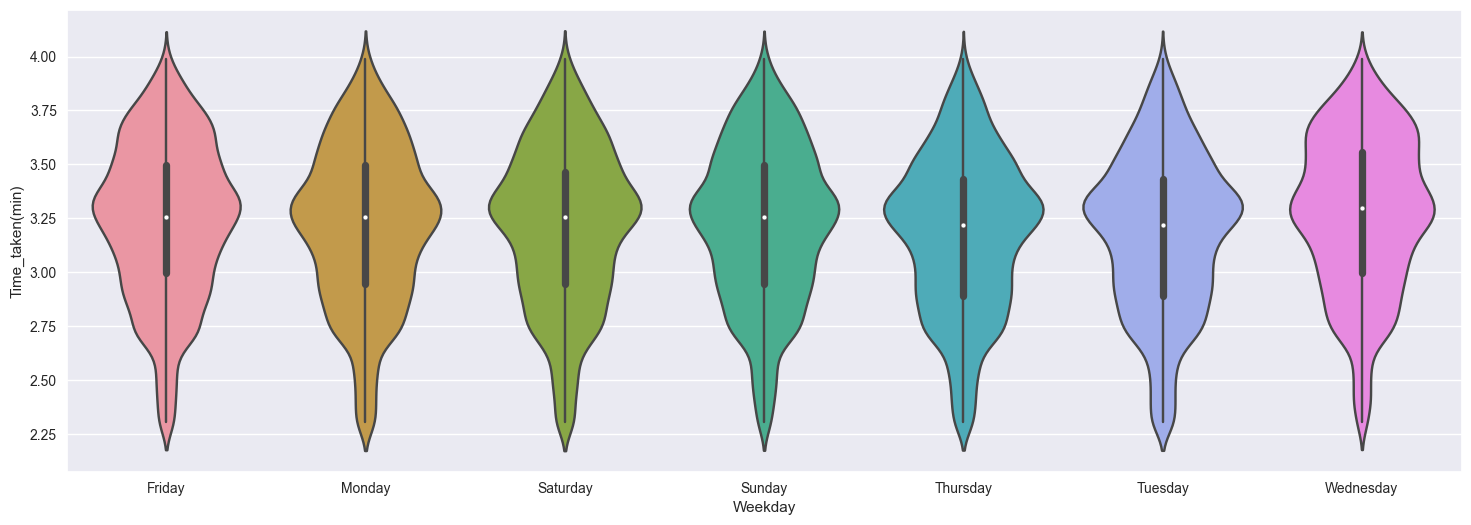

In [149]:
# Apply logarithmic transformation to the 'Weekday' column in the DataFrame
transformed_data = log_transform('Weekday').copy()

# Plot a violin plot using the transformed data
plot_violin(df=transformed_data, x='Weekday')

As illustrated above, now the distributions exhibit characteristics that fairly resemble those of a normal distribution. However, Anova test also has assumption of equal variance. Hence, now i will test whether these samples have the same variance.

In [148]:
# Create a list of Series objects, each containing the log-transformed target values
# for a specific weekday category
cats = [transformed_data[transformed_data['Weekday'] == cat][target_col]
        for cat in transformed_data['Weekday'].unique()]

# Check for homogeneity of variances among the different weekday categories
check_homo(cats)

p-value: 0.9085546184926692 >= 0.05
Variances are equal


Since all assumptions are met, i move on conducting one-way ANOVA test

In [150]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def one_way_Anova_and_post_hoc_test(df, categorical_col, target_col):
    """
    Perform a one-way ANOVA test and a post-hoc Tukey's HSD test to compare means across different groups.
    """
    # Prepare a list of target column values for each category in the categorical column
    values_for_each_group = [df[df[categorical_col] == cat][target_col]
                             for cat in df[categorical_col].unique()]
    
    # Perform one-way ANOVA test
    statistic, p_value = f_oneway(*values_for_each_group)
    
    # Create a DataFrame to store the ANOVA results
    result = pd.DataFrame({'Feature': [categorical_col], 'F_score': [statistic], 'p_value': [p_value]})

    # Print the results and perform post-hoc testing if the p-value is significant
    if p_value < 0.05:
        print('Reject the null hypothesis.\n'
              'At a significance level of 5%, there is enough evidence to conclude that\n'
              'there exists a statistically significant difference among the means of at least two groups.')
        display(set_frame_style(result))
        
        # Perform post-hoc Tukey's HSD test
        posthoc = pairwise_tukeyhsd(df[target_col], df[categorical_col], alpha=0.05)
        print(posthoc)
    else:
        print('Fail to Reject the null hypothesis.\n'
              'At a significance level of 5%, there is not enough evidence to conclude that\n'
              'there exists a statistically significant difference among the means of at least two groups.')
        display(set_frame_style(result))
one_way_Anova_and_post_hoc_test(transformed_data, 'Weekday', target_col)

Reject the null hypothesis.
At a significance level of 5%, there is enough evidence to conclude that
there exists a statistically significant difference among the means of at least two groups.


,Feature,F_score,p_value
0,Weekday,48.784541,0.000000


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
  Friday    Monday  -0.0243  0.005  -0.044 -0.0046   True
  Friday  Saturday  -0.0279 0.0005 -0.0475 -0.0083   True
  Friday    Sunday  -0.0186 0.0762 -0.0382   0.001  False
  Friday  Thursday  -0.0622    0.0 -0.0818 -0.0427   True
  Friday   Tuesday  -0.0587    0.0 -0.0782 -0.0392   True
  Friday Wednesday   0.0314    0.0  0.0125  0.0504   True
  Monday  Saturday  -0.0036 0.9984 -0.0239  0.0166  False
  Monday    Sunday   0.0057 0.9821 -0.0146  0.0259  False
  Monday  Thursday  -0.0379    0.0 -0.0581 -0.0178   True
  Monday   Tuesday  -0.0344    0.0 -0.0545 -0.0142   True
  Monday Wednesday   0.0557    0.0  0.0361  0.0754   True
Saturday    Sunday   0.0093 0.8224 -0.0109  0.0295  False
Saturday  Thursday  -0.0343    0.0 -0.0544 -0.0142   True
Saturday   Tuesday  -0.0307 0.0001 -0.0508 -0.0107   True
Saturday Wedne

In the post-hoc test, the null hypothesis is that the paired means are equivalent. Rejecting this null hypothesis indicates a significant difference between the two means.

As illustrated in the table above, most paired categories exhibit equal means, except for the pairs (Friday, Sunday),(Monday, Saturday),(Monday, Sunday), (Saturday, Sunday) and (Thursday, Tuesday)

It is reasonable that there is no discernible difference in the mean between Saturday and Sunday. As weekends, both days share similar characteristics that could influence delivery times in a same way. 

**2. Orderd_Picked_Duration_Train**

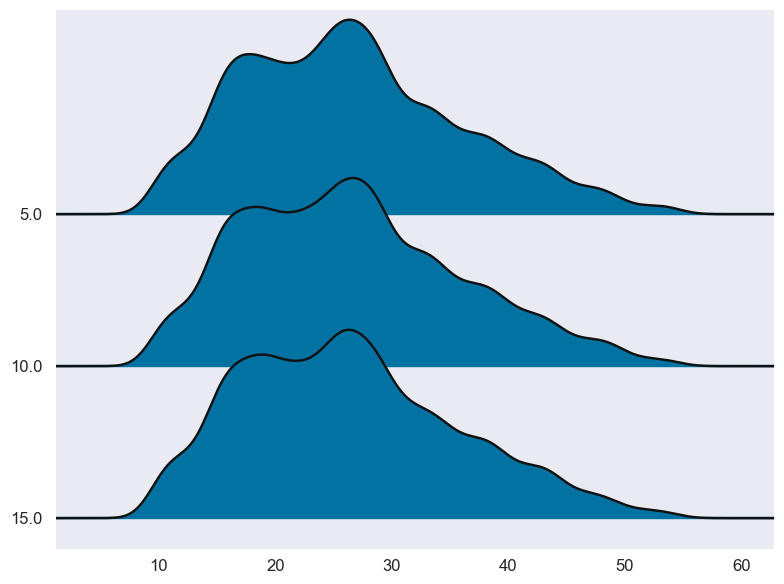

In [157]:
import joypy
def joyplot(x,df=df_train, target_col=target_col,figsize=(8,6)):
  ax, figure = joypy.joyplot(df, target_col, x, figsize=figsize)

joyplot(x='Orderd_Picked_Duration_Train')


the plot shows that the distributions for three categories are positively skewed. Now, let's implement normalization

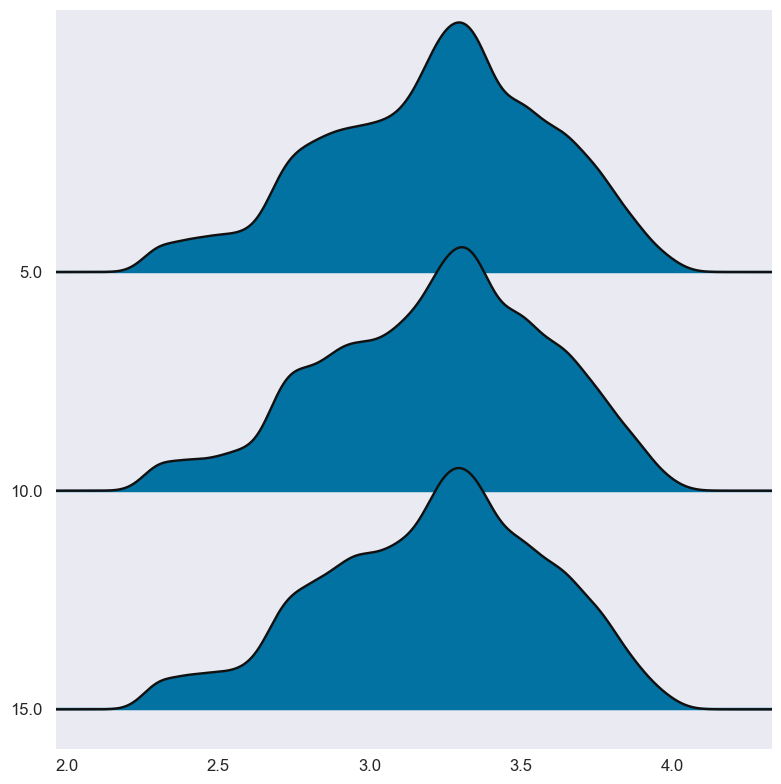

In [153]:
transformed_data = log_transform(cat_col='Orderd_Picked_Duration_Train')

joyplot('Orderd_Picked_Duration_Train', transformed_data)

In [154]:
cats = [df_train[df_train['Orderd_Picked_Duration_Train']== cat][target_col]\
         for cat in df_train['Orderd_Picked_Duration_Train'].unique()]
check_homo(cats)

p-value: 0.8778442066556899 >= 0.05
Variances are equal


In [155]:
one_way_Anova_and_post_hoc_test(transformed_data, 'Orderd_Picked_Duration_Train', target_col)


Fail to Reject the null hypothesis.
At a significance level of 5%, there is not enough evidence to conclude that
there exists a statistically significant difference among the means of at least two groups.


,Feature,F_score,p_value
0,Orderd_Picked_Duration_Train,2.200143,0.110800


**3. Time_Of_Day**

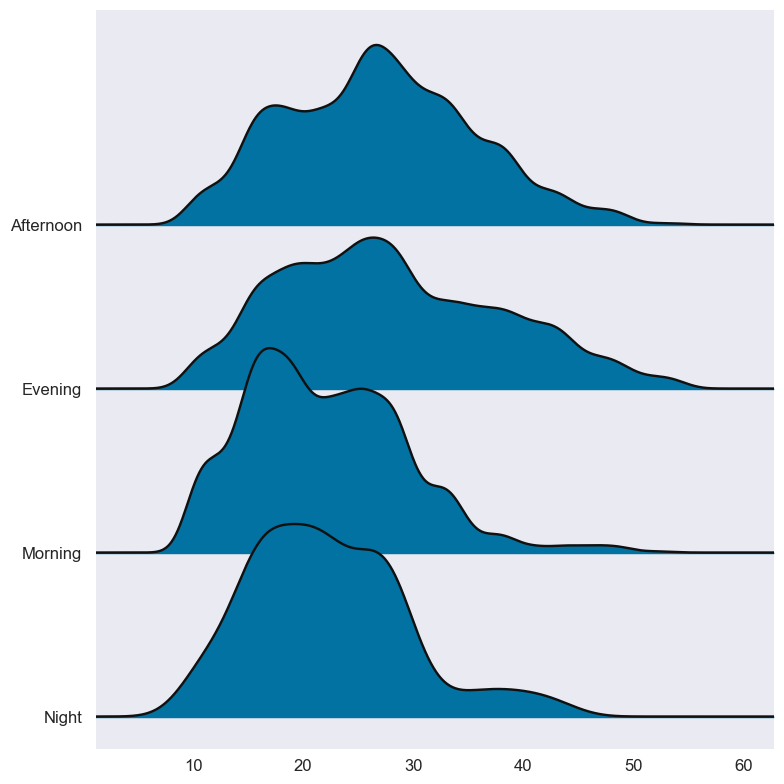

In [156]:
joyplot(x='Time_Of_Day')

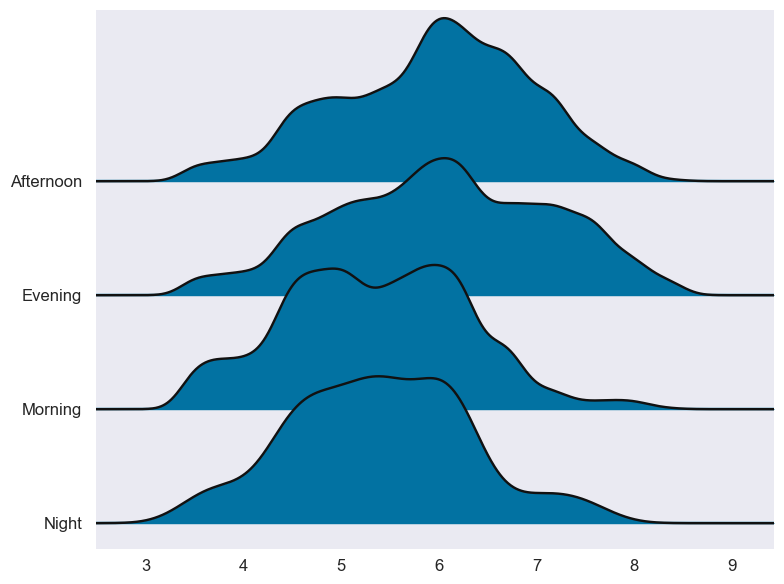

In [158]:
transformed_target_col, lamb = stats.boxcox(df_train[target_col])
transformed_data = df_train[['Time_Of_Day']].copy()
transformed_data[target_col] = transformed_target_col
joyplot(df=transformed_data, x='Time_Of_Day')

In [159]:
cats = [transformed_data[transformed_data['Time_Of_Day']==cat][target_col]\
         for cat in transformed_data['Time_Of_Day'].unique()]
check_homo(cats)

p-value: 2.712965232196429e-90 < 0.05
Variances are not equal


Since The assumption of equal variances is violated, I will use modified version of one-way Anova test, called Welch's Anova.

In [160]:
def welch_anova_test(cat_col, target_col=target_col, df=df_train):
  welch_anova_df = pg.welch_anova(dv=target_col, between=cat_col, data= df)
  alpha = 0.05 
  p_value = welch_anova_df['p-unc'].values
  display(set_frame_style(welch_anova_df))
  if (p_value < alpha).any():
    print(f'p_value: {p_value} < 0.05\
          \nReject the null hypothesis.\
          \nAt a significance level of 5%, there is enough evidence to suggest that\
          \nthere is significant difference between the means of at least one pair of samples')
  else: 
    print(f'p_value: {p_value} > 0.05\
          \nFail to Reject the null hypothesis.\
          \nAt a significance level of 5%, there is not enough evidence to suggest that\
          \nthere is significant difference between the means of at least one pair of samples')

In [161]:
welch_anova_test('Time_Of_Day',df=transformed_data)


,Source,ddof1,ddof2,F,p-unc,np2
0,Time_Of_Day,3,1956.715484,1015.944695,0.000000,0.060483


p_value: [0.] < 0.05          
Reject the null hypothesis.          
At a significance level of 5%, there is enough evidence to suggest that          
there is significant difference between the means of at least one pair of samples


Now, let's execute a test to determine which group differences are statistically significant. I opted for the Games-Howel test, because it is robust to heterogeneity of variances, hence making it complementary to Welch ANova 

In [163]:
def post_hoc_test_welch(cat_col, target_col=target_col, df=df_train):
    """ Perform Welch's ANOVA post-hoc test using the Games-Howell method. """
    # Perform pairwise comparisons using the Games-Howell test
    post_hoc_test_df = pg.pairwise_gameshowell(dv=target_col, between=cat_col, data=df)

    alpha = 0.05

    # Add a new column 'Reject' to indicate whether the null hypothesis is rejected based on p-value
    post_hoc_test_df['Reject'] = post_hoc_test_df['pval'] < alpha

    # Display the DataFrame with post-hoc test results
    display(post_hoc_test_df)

# Example usage: Perform post-hoc test on 'Time_Of_Day' using the transformed data
post_hoc_test_welch('Time_Of_Day', df=transformed_data)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges,Reject
0,Afternoon,Evening,5.948559,6.044263,-0.095704,0.011966,-7.997878,25223.245648,1.741163e-11,-0.089656,True
1,Afternoon,Morning,5.948559,5.360938,0.587621,0.014027,41.893133,17809.796024,0.000000e+00,0.606273,True
2,Afternoon,Night,5.948559,5.402930,0.545629,0.046041,11.850864,436.964282,3.474998e-13,0.553234,True
3,Evening,Morning,6.044263,5.360938,0.683325,0.012909,52.932551,16769.264714,0.000000e+00,0.642257,True
4,Evening,Night,6.044263,5.402930,0.641333,0.045713,14.029475,424.666151,6.468159e-13,0.581510,True
5,Morning,Night,5.360938,5.402930,-0.041992,0.046295,-0.907044,446.653507,8.011028e-01,-0.044712,False


As illustrated in the table above, most paired categories exhibit different means, except for the pairs Morning and Night


In [164]:
morning_v_night_data = df_train[df_train['Time_Of_Day'].isin(['Morning', 'Night'])]

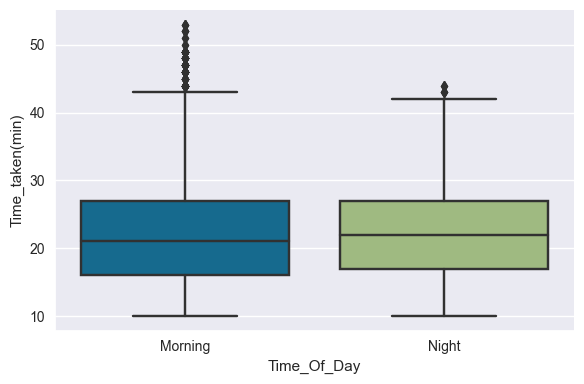

In [169]:
# Create a box plot to visualize the distribution of the target column across different times of day
sns.catplot(x='Time_Of_Day', y=target_col, data=morning_v_night_data, kind='box', height=4, aspect=1.5)

# Overlay a strip plot to show individual data points on top of the box plot

# Display the combined plot
plt.show()

In [170]:
morning=len(df_train[df_train['Time_Of_Day']=='Morning'])
night=len(df_train[df_train['Time_Of_Day']=='Night'])
morning, night

(8038, 403)

Although the test shows that there is no difference between the means of the two samples, we can not conclude that there is no significant difference between the two samples since the sample sizes are highly unequal. The greater the differences in sample sizes between the groups, the lower the statistical power of an ANOVA test

**4. Weatherconditions**

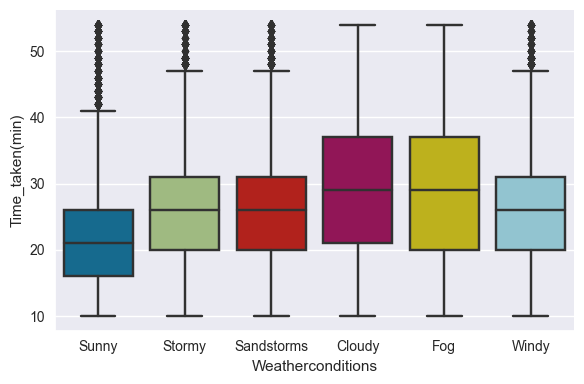

In [171]:
sns.catplot(x = 'Weatherconditions', y=target_col, data=df_train, kind='box', height=4, aspect=1.5)

plt.show()

In [172]:
for cat in df_train['Weatherconditions'].unique():
  print(f'size of {cat}:', len(df_train[df_train['Weatherconditions']==cat]))

size of Sunny: 6614
size of Stormy: 6997
size of Sandstorms: 6852
size of Cloudy: 6950
size of Fog: 7116
size of Windy: 6839


There is not much difference between sample sizes, hence we can safely perform ANOVA to test the difference between the means between different groups in the variable

As we can see from the boxplots above, the data is pretty skewed, hence we will need to conduct normalization for those groups.

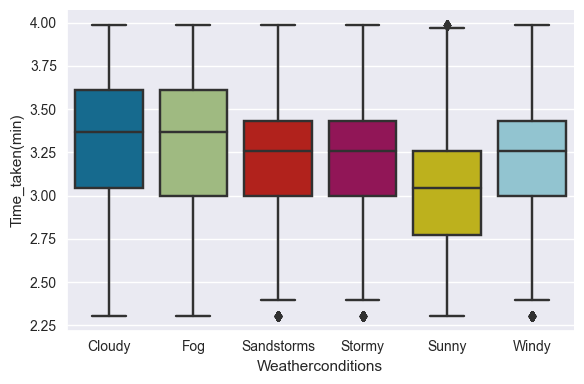

In [173]:
transformed_data = log_transform('Weatherconditions')
sns.catplot(x = 'Weatherconditions', y=target_col, data=transformed_data, kind='box', height=4, aspect=1.5)


It looks more normal distributed now. Let's perform Anova Test. 

In [174]:
one_way_Anova_and_post_hoc_test(transformed_data, 'Weatherconditions', target_col=target_col)

Reject the null hypothesis.
At a significance level of 5%, there is enough evidence to conclude that
there exists a statistically significant difference among the means of at least two groups.


,Feature,F_score,p_value
0,Weatherconditions,533.800994,0.000000


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    Cloudy        Fog   0.0005    1.0 -0.0165  0.0176  False
    Cloudy Sandstorms  -0.0998    0.0  -0.117 -0.0826   True
    Cloudy     Stormy  -0.0979    0.0  -0.115 -0.0808   True
    Cloudy      Sunny  -0.2725    0.0 -0.2898 -0.2551   True
    Cloudy      Windy  -0.0896    0.0 -0.1068 -0.0724   True
       Fog Sandstorms  -0.1004    0.0 -0.1175 -0.0833   True
       Fog     Stormy  -0.0984    0.0 -0.1154 -0.0814   True
       Fog      Sunny   -0.273    0.0 -0.2903 -0.2557   True
       Fog      Windy  -0.0901    0.0 -0.1073  -0.073   True
Sandstorms     Stormy   0.0019 0.9995 -0.0152  0.0191  False
Sandstorms      Sunny  -0.1726    0.0 -0.1901 -0.1552   True
Sandstorms      Windy   0.0102 0.5405 -0.0071  0.0275  False
    Stormy      Sunny  -0.1746    0.0 -0.1919 -0.1572   True
    Stormy      Windy   

From the ANOVA test and post hoc test above, we can see that there is statistical difference between the means of mosts of the paired groups except for the pairs (Cloudy, Fog), (Sandstorms, Stormy), (Sandstorms, Windy), (Stormy, Windy)

**5. Road_traffic_density**

<AxesSubplot: xlabel='Time_taken(min)', ylabel='Density'>

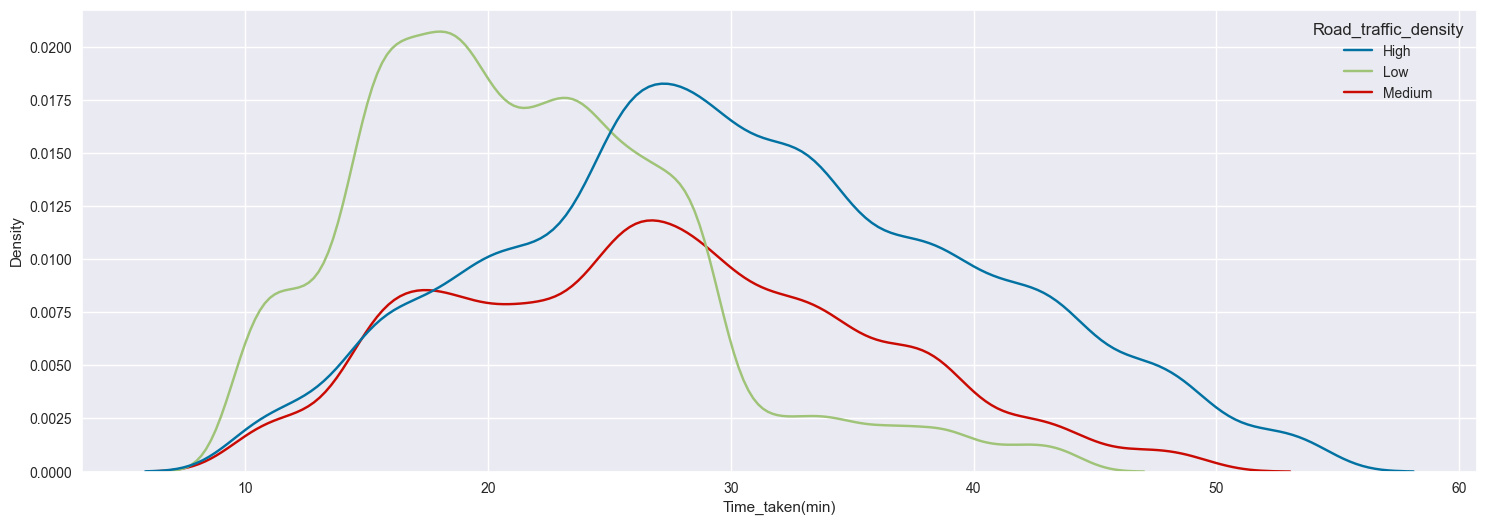

In [175]:
sns.kdeplot(df_train[['Road_traffic_density', target_col]], hue='Road_traffic_density', x=target_col)

In [176]:
for cat in df_train['Road_traffic_density'].unique():
  print(f'Size of {cat}:', len(df_train[df_train['Road_traffic_density']==cat]))


Size of High: 17262
Size of Low: 13981
Size of Medium: 10125


In [178]:
transformed_data = log_transform('Road_traffic_density')


the distributions are not still normal. Hence, I will use the last resort which is the Welch Anova Test

In [179]:
welch_anova_test('Road_traffic_density')
post_hoc_test_welch('Road_traffic_density')

,Source,ddof1,ddof2,F,p-unc,np2
0,Road_traffic_density,2,24772.630373,4832.030386,0.000000,0.172240


p_value: [0.] < 0.05          
Reject the null hypothesis.          
At a significance level of 5%, there is enough evidence to suggest that          
there is significant difference between the means of at least one pair of samples


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges,Reject
0,High,Low,30.447631,21.494457,8.953174,0.093224,96.039338,30659.273181,0.000000e+00,1.054530,True
1,High,Medium,30.447631,26.899556,3.548075,0.111959,31.690971,23381.488759,2.243317e-12,0.383843,True
2,Low,Medium,21.494457,26.899556,-5.405099,0.102135,-52.921252,18734.389721,3.118616e-12,-0.715508,True


**6. Vehicle_condition**

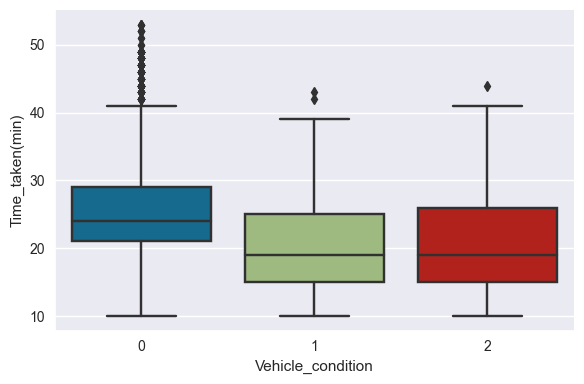

In [180]:
sns.catplot(x = 'Vehicle_condition', y=target_col, data=morning_v_night_data, kind='box', height=4, aspect=1.5)

plt.show() 

In [181]:
for cat in df_train['Vehicle_condition'].unique():
  print(f'Size of {cat}:', len(df_train[df_train['Vehicle_condition']==cat]))

Size of 2: 13755
Size of 0: 13925
Size of 1: 13688


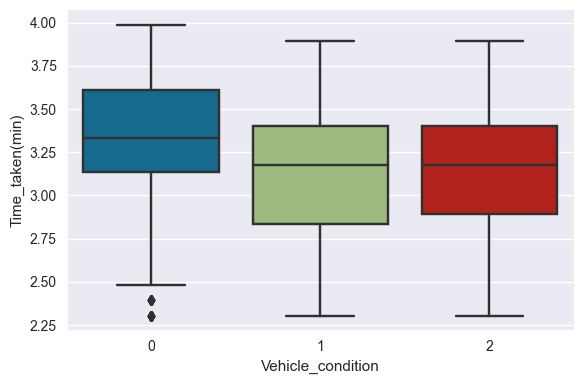

In [182]:
transformed_data = log_transform('Vehicle_condition')
sns.catplot(x = 'Vehicle_condition', y=target_col, data=transformed_data, kind='box', height=4, aspect=1.5)



In [183]:
one_way_Anova_and_post_hoc_test(transformed_data, 'Vehicle_condition', target_col=target_col)

Reject the null hypothesis.
At a significance level of 5%, there is enough evidence to conclude that
there exists a statistically significant difference among the means of at least two groups.


,Feature,F_score,p_value
0,Vehicle_condition,1742.418311,0.000000


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.2186    0.0 -0.2285 -0.2087   True
     0      2  -0.2131    0.0  -0.223 -0.2032   True
     1      2   0.0055 0.3995 -0.0045  0.0154  False
----------------------------------------------------


There is no statistically difference between the mean between the two group (1,2). 

**7. Type_of_order**

In [184]:
for cat in df_train['Type_of_order'].unique():
  print(f'size of {cat}:', len(df_train[df_train['Type_of_order']==cat]))

size of Snack: 10419
size of Drinks: 10302
size of Buffet: 10226
size of Meal: 10421


In [ ]:
sns.catplot(x = 'Type_of_order', y=target_col, data=morning_v_night_data, kind='box', height=4, aspect=1.5)

plt.show()

<AxesSubplot: xlabel='Time_taken(min)', ylabel='Density'>

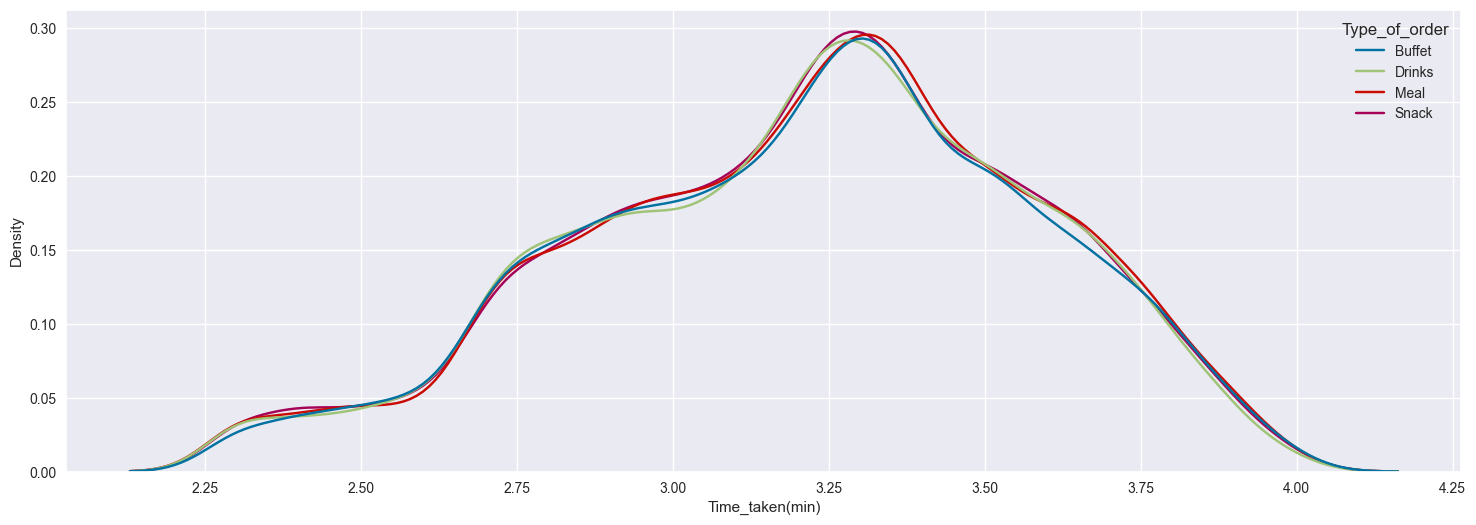

In [186]:
transformed_data = log_transform('Type_of_order')
sns.kdeplot(hue = 'Type_of_order', x=target_col, data=transformed_data)


From the two graphs above we can expect the means between different types of order is not statistically different. Let's use Anova to test the assumption.


In [187]:
one_way_Anova_and_post_hoc_test(transformed_data, 'Type_of_order', target_col=target_col)

Fail to Reject the null hypothesis.
At a significance level of 5%, there is not enough evidence to conclude that
there exists a statistically significant difference among the means of at least two groups.


,Feature,F_score,p_value
0,Type_of_order,0.646669,0.584956


yes, there is no statistical difference between any groups of the variable

**9. Multiple_deliveries**

In [188]:
for cat in df_train['multiple_deliveries'].unique():
  print(f'size of {cat}:', len(df_train[df_train['multiple_deliveries']==cat]))

size of 0.0: 12974
size of 1.0: 26176
size of 3.0: 337
size of 2.0: 1881


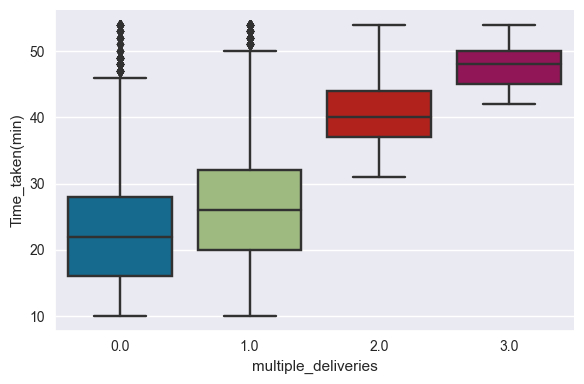

In [189]:
sns.catplot(x = 'multiple_deliveries', y=target_col, data=df_train, kind='box', height=4, aspect=1.5)

plt.show()

Although we cannot perform ANOVA test due to the drastical difference in sizes, It is shown in the graph that the mean of time_taken is larger for the larger number of multiple deliveries

**10. Delivery_person_Age_Range**

In [190]:
for cat in df_train['Delivery_person_Age_Range'].unique():
  print(f'Size of {cat}:', len(df_train[df_train['Delivery_person_Age_Range']==cat]))

Size of 36-40: 8479
Size of 31-35: 10488
Size of 20-25: 12146
Size of 26-30: 10255


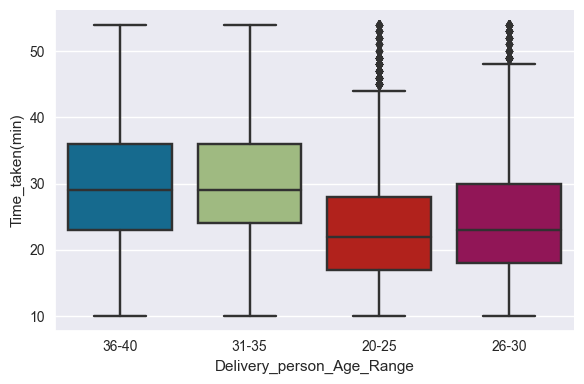

In [191]:
sns.catplot(x = 'Delivery_person_Age_Range', y=target_col, data=df_train, kind='box', height=4, aspect=1.5)


<AxesSubplot: xlabel='Time_taken(min)', ylabel='Density'>

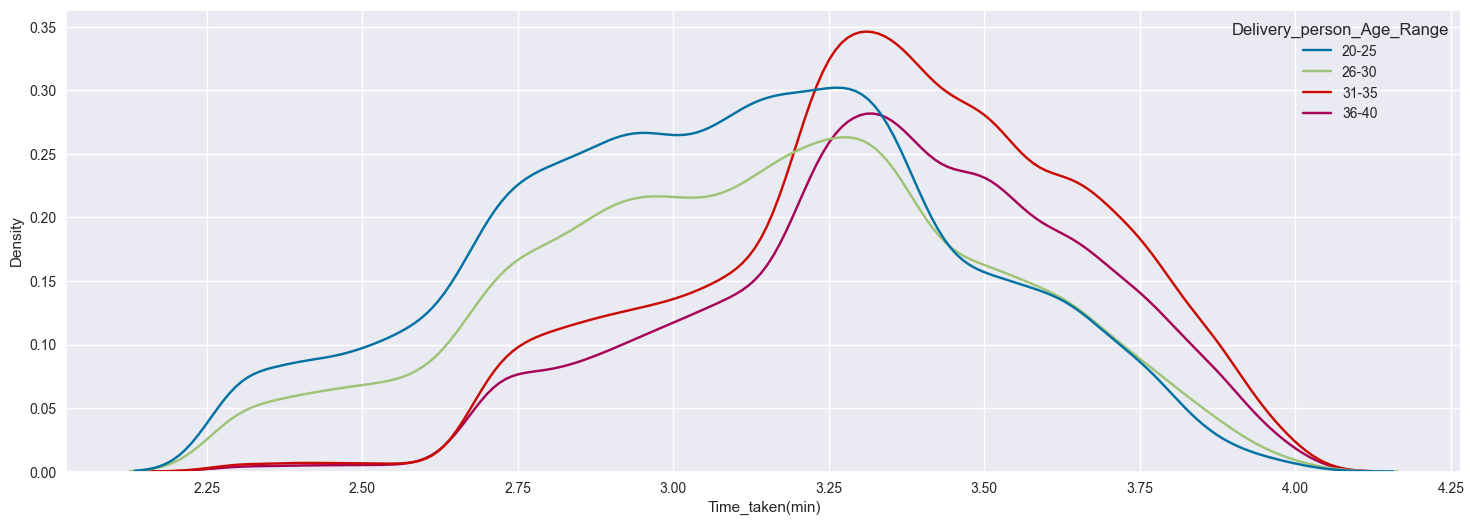

In [192]:
transformed_data = log_transform('Delivery_person_Age_Range', target_col=target_col, df=df_train)
sns.kdeplot(hue = 'Delivery_person_Age_Range', x=target_col, data=transformed_data)


In [193]:
one_way_Anova_and_post_hoc_test(transformed_data, 'Delivery_person_Age_Range', target_col=target_col)

Reject the null hypothesis.
At a significance level of 5%, there is enough evidence to conclude that
there exists a statistically significant difference among the means of at least two groups.


,Feature,F_score,p_value
0,Delivery_person_Age_Range,1685.299891,0.000000


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 20-25  26-30   0.0519    0.0    0.04 0.0638   True
 20-25  31-35   0.2648    0.0  0.2529 0.2766   True
 20-25  36-40   0.2611    0.0  0.2485 0.2737   True
 26-30  31-35   0.2129    0.0  0.2005 0.2252   True
 26-30  36-40   0.2092    0.0  0.1962 0.2222   True
 31-35  36-40  -0.0037 0.8866 -0.0166 0.0093  False
---------------------------------------------------


There is no statistical significant difference in mean between the group 31-35 and 36-40

When conducting an Analysis of Variance (ANOVA) test, the primary goal is to determine whether there are significant differences in means between groups. While ANOVA can provide valuable information about the variability within and between groups, it does not provide information about the direction or causality of these differences. It only tells us that there are differences, not why they exist or what causes them. In addition, ANOVA test does not control for potential confounding variables that may influence the relationship between the independent variable group and the dependent variable. Without controlling for confounding variables, we cannot infer causation from the observed associations. 

#### **Outlier Detection**




Let's plot the kernel density estimation (KDE) ( a non-parametric way to estimate the probability density function)

<Figure size 1600x800 with 0 Axes>

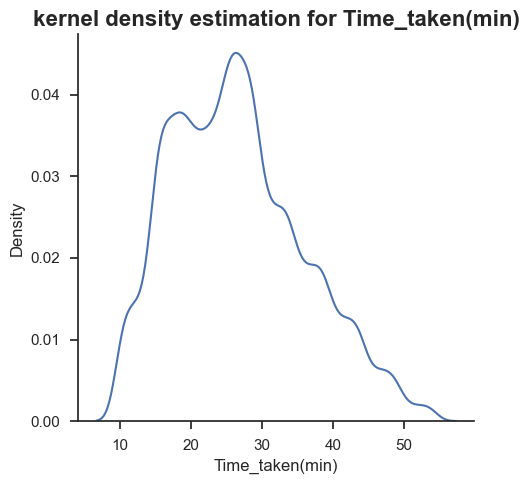

In [194]:
plt.figure(figsize=(16,8))
sns.set_theme(style='ticks')
sns.displot(df_train, x = target_col,kind='kde')
plt.title(f'kernel density estimation for {target_col}', fontdict=fontdict(16))
plt.grid(False)
plt.tight_layout()


In [195]:
def remove_outliers(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1 
  upper_boundary = q3 + 1.5*iqr 
  lower_boundary = q3 - 1.5*iqr
  new_df = df.loc[(df[col]>lower_boundary)&(df[col]<upper_boundary)]
  return new_df

<AxesSubplot: >

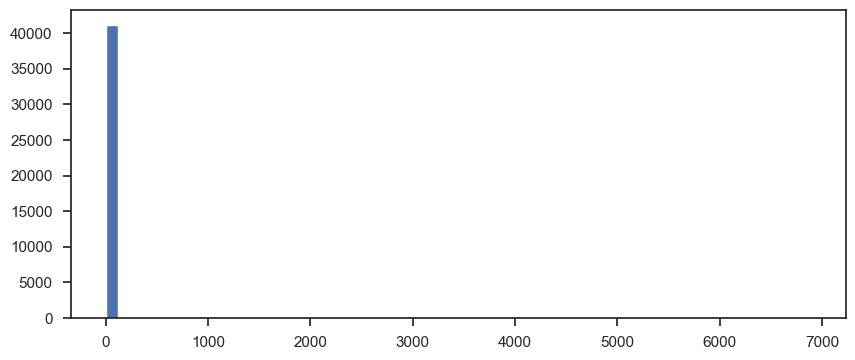

In [196]:
df_train['Distance (km)'].hist(bins=60,figsize=(10,4),grid=False)

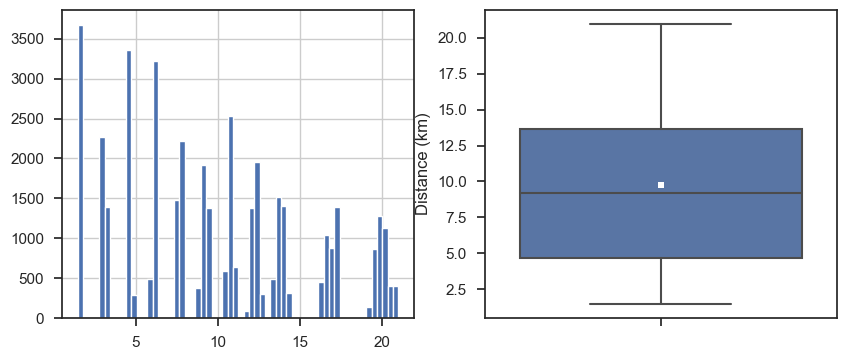

In [197]:
fig,axes=plt.subplots(1,2,figsize=(16,7))
df_train = remove_outliers(df_train, 'Distance (km)')
df_test = remove_outliers(df_test, 'Distance (km)')
df_train['Distance (km)'].hist(bins=60,figsize=(10,4), ax=axes[0])
sns.boxplot(data=df_train, y='Distance (km)', ax=axes[1],showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
plt.show()




## Further Analysis

In [198]:
def remove_outliers_time_taken_for_each_group(df, cat_col1, target_col):
  remove_outliers_dfs=df_train.groupby(cat_col1).apply(lambda f: remove_outliers(f,target_col)).reset_index(drop=True)
  return remove_outliers_dfs

## Feature Selections

**Removing features with too much variance**

In [199]:
for col in df_train.columns:
  frac_unique = df_train[col].unique().shape[0]/df_train.shape[0]
  if frac_unique > 0.5:
    print(col)

**Using correlation**

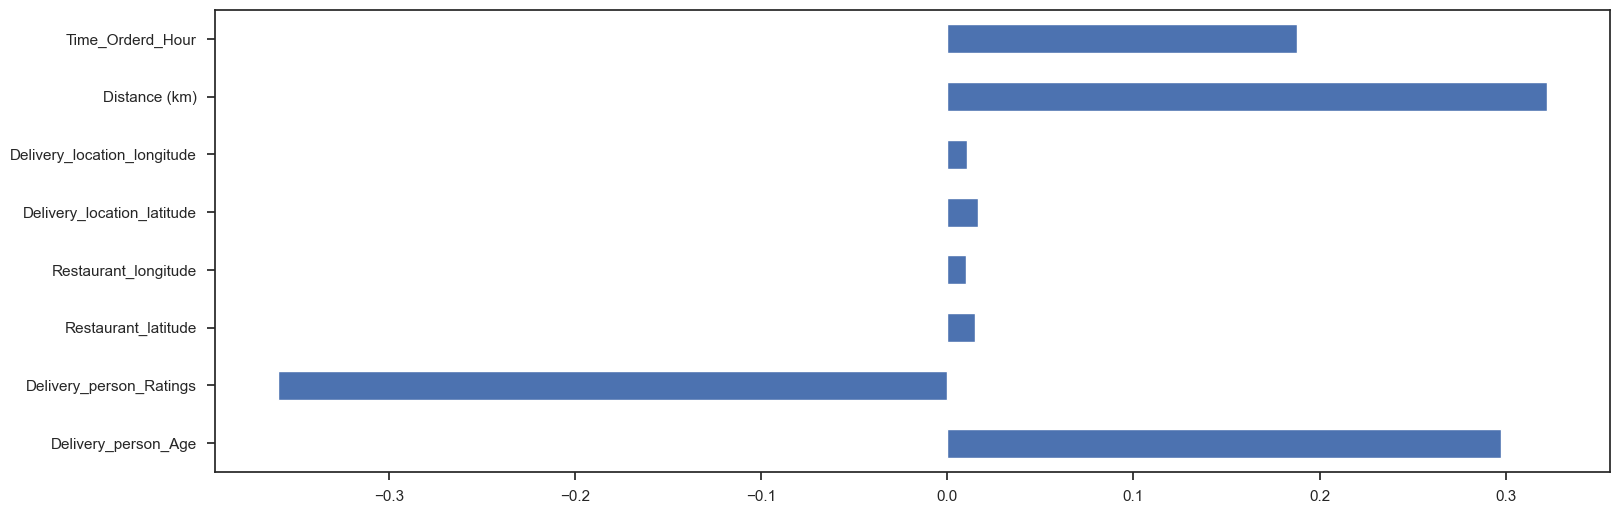

In [201]:
df_train.corr(numeric_only=True).loc[target_col][:-1].plot.barh()
plt.grid(False)


In [202]:
continuous_cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude',
                   'Delivery_location_latitude', 'Delivery_location_longitude', 'Distance (km)','Time_Orderd_Hour']
target_col = target_col  # Replace with your actual target column name

# Assuming df_train is your DataFrame


for col in df_train.columns:
    if col not in continuous_cols+[target_col]:
        df_train[col] = df_train[col].astype('category')

cat_cols=df_train.select_dtypes(include='category').columns.to_list()


In [203]:
for c in df_train.columns[:-1]:
  if is_numeric_dtype(df_train[c]):
    correlation, p_value = pearsonr(df_train[c], df_train[target_col])
    print(f'{c:<40}: {correlation : .4f},significant: {p_value <=0.05}')

Delivery_person_Age                     :  0.2975,significant: True
Delivery_person_Ratings                 : -0.3597,significant: True
Restaurant_latitude                     :  0.0146,significant: True
Restaurant_longitude                    :  0.0098,significant: True
Delivery_location_latitude              :  0.0163,significant: True
Delivery_location_longitude             :  0.0103,significant: True
Distance (km)                           :  0.3220,significant: True
Time_Orderd_Hour                        :  0.1876,significant: True
Time_taken(min)                         :  1.0000,significant: True


In [204]:
predictors = continuous_cols


In [205]:
df_train

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Distance (km),Weekday,Orderd_Picked_Duration_Train,Time_Orderd_Hour,...,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Delivery_person_Age_Range
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,3.03,Saturday,15.0,11,...,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24.0,36-40
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,20.18,Friday,5.0,19,...,Stormy,High,2,Snack,scooter,1.0,No,Urban,33.0,31-35
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,1.55,Saturday,15.0,8,...,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26.0,20-25
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,7.79,Tuesday,10.0,18,...,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Urban,21.0,36-40
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,6.21,Saturday,15.0,13,...,Cloudy,High,1,Snack,scooter,1.0,No,Urban,30.0,31-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,30.0,4.8,26.902328,75.794257,26.912328,75.804257,1.49,Thursday,10.0,11,...,Windy,High,1,Meal,motorcycle,0.0,No,Urban,32.0,26-30
45589,21.0,4.6,0.000000,0.000000,0.070000,0.070000,11.01,Wednesday,15.0,19,...,Windy,High,0,Buffet,motorcycle,1.0,No,Urban,36.0,20-25
45590,30.0,4.9,13.022394,80.242439,13.052394,80.272439,4.66,Friday,15.0,23,...,Cloudy,Low,1,Drinks,scooter,0.0,No,Urban,16.0,26-30
45591,20.0,4.7,11.001753,76.986241,11.041753,77.026241,6.23,Monday,5.0,13,...,Cloudy,High,0,Snack,motorcycle,1.0,No,Urban,26.0,20-25


In [206]:
X=df_train.drop(target_col,axis=1)

y=df_train[target_col]



In [207]:
Encoder=LabelEncoder()
categorical_columns = X.select_dtypes(include='category').columns.to_list()
X[categorical_columns]=X[categorical_columns].apply(lambda col: Encoder.fit_transform(col))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [208]:
continuous_cols = X_train.select_dtypes(include='float64').columns.to_list()
st_scaler = StandardScaler()
n_scaler = MinMaxScaler()
X_train_st_scaled = st_scaler.fit_transform(X_train[continuous_cols])
X_test_st_scaled = st_scaler.transform(X_test[continuous_cols])
X_train_n_scaled = n_scaler.fit_transform(X_train[continuous_cols])
X_test_n_scaled = n_scaler.transform(X_test[continuous_cols])



In [209]:
X_train_st_continuous = pd.DataFrame(X_train_st_scaled,columns=X_train[continuous_cols].columns)
X_test_st_continuous = pd.DataFrame(X_test_st_scaled,columns=X_train[continuous_cols].columns)
X_train_n_continuous = pd.DataFrame(X_train_n_scaled, columns=X_train[continuous_cols].columns)

In [210]:
X_train_ = pd.concat([X_train_st_continuous, X_train[X_train.columns.difference(continuous_cols)].reset_index(drop=True)], axis=1)
X_test_ = pd.concat([X_test_st_continuous, X_test[X_test.columns.difference(continuous_cols)].reset_index(drop=True)],axis=1)


In [211]:
def perform_grid_search(model,param_grid, cv=5, scoring='r2'):
  model = model()
  grid_search = GridSearchCV(model, param_grid=param_grid,cv=5, scoring='r2')
  grid_search.fit(X_train_, y_train)
  return grid_search

def analyze_results(grid_search):
  print('Best Hyperparameters:', grid_search.best_params_)
  print('Best Cross-Validated scores:', grid_search.best_score_)
  cv_results = grid_search.cv_results_
  mean_test_scores = cv_results['mean_test_score']
  std_test_scores = cv_results['std_test_score']
  for params, mean_score, std_score in zip(cv_results['params'], mean_test_scores, std_test_scores):
    print(f'Hyperparameters: {params}, Mean Test Score: {mean_score}, Std Test Score: {std_score}')

def cross_val_score_(model,param,X_train, y_train,cv=5,scoring='r2'):
  model = model(**param)
  scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
  mean_score = np.mean(scores)
  return mean_score


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1729
[LightGBM] [Info] Number of data points in the train set: 2308, number of used features: 23
[LightGBM] [Info] Start training from score 26.477036
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1874
[LightGBM] [Info] Number of data points in the train set: 7502, number of used features: 24
[LightGBM] [Info] Start training from score 26.553986
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

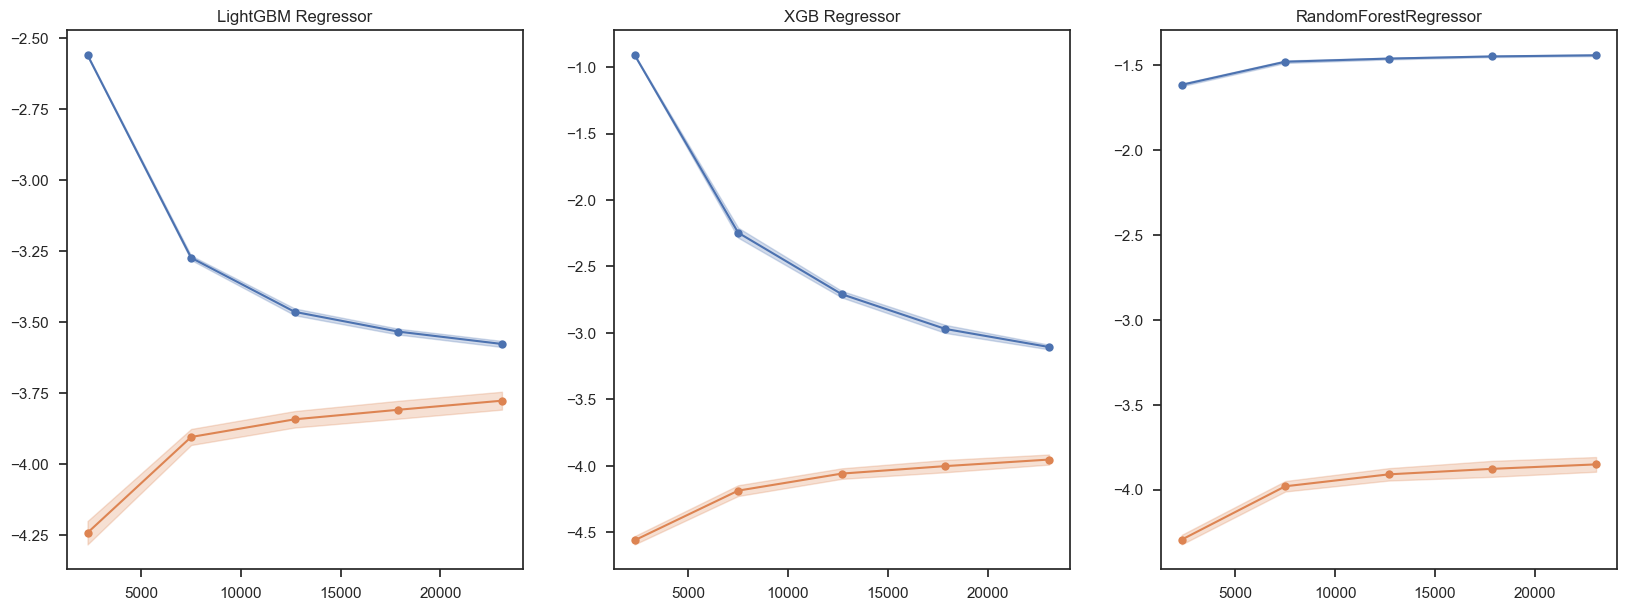

In [160]:
fig,axes = plt.subplots(ncols=3, figsize=(20,7))
lgb = LGBMRegressor()
lc = LearningCurve(lgb, scoring='neg_root_mean_squared_error',ax=axes[0])
lc.fit(X_train_, y_train)
xgb = XGBRegressor()
lc2 = LearningCurve(xgb, scoring='neg_root_mean_squared_error',ax=axes[1])
lc2.fit(X_train_,y_train)

rd = RandomForestRegressor()
lc3 = LearningCurve(rd, scoring='neg_root_mean_squared_error',ax=axes[2])
lc3.fit(X_train_,y_train)
axes[0].set_title('LightGBM Regressor')
axes[1].set_title('XGB Regressor')
axes[2].set_title('RandomForestRegressor')
plt.show()

From the graph above, we can expect that the LightGBM Regressor Model would perform better than than the other two models.

In [161]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators',100,1000)
  max_depth = trial.suggest_int('max_depth', 100, 1000)
  learning_rate = trial.suggest_float('learning_rate',0.1,1)
  num_leaves= trial.suggest_int('num_leaves',10,50)
  model = LGBMRegressor(n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      num_leaves=num_leaves)

  #njob: used to specifies the number of parallel jobs to run, where '-1' means using all available processors.
  score = cross_val_score(model,X_train_,y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
  return score

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-04-23 18:13:33,590] A new study created in memory with name: no-name-634bc0c1-95e8-4ca1-8703-0c3069353f97


In [162]:
study.optimize(objective,n_trials = 100)

[I 2024-04-23 18:13:49,104] Trial 0 finished with value: -22.137231283080624 and parameters: {'n_estimators': 437, 'max_depth': 956, 'learning_rate': 0.7587945476302645, 'num_leaves': 34}. Best is trial 0 with value: -22.137231283080624.
[I 2024-04-23 18:13:52,810] Trial 1 finished with value: -14.786795193521963 and parameters: {'n_estimators': 240, 'max_depth': 240, 'learning_rate': 0.15227525095137953, 'num_leaves': 45}. Best is trial 1 with value: -14.786795193521963.
[I 2024-04-23 18:14:00,354] Trial 2 finished with value: -15.27228225121512 and parameters: {'n_estimators': 641, 'max_depth': 737, 'learning_rate': 0.1185260448662222, 'num_leaves': 49}. Best is trial 1 with value: -14.786795193521963.
[I 2024-04-23 18:14:04,109] Trial 3 finished with value: -16.384441437466627 and parameters: {'n_estimators': 850, 'max_depth': 291, 'learning_rate': 0.26364247048639056, 'num_leaves': 17}. Best is trial 1 with value: -14.786795193521963.
[I 2024-04-23 18:14:06,063] Trial 4 finished wi

In [163]:
best_params=study.best_params
best_params

{'n_estimators': 209,
 'max_depth': 546,
 'learning_rate': 0.13094966900369656,
 'num_leaves': 47}

In [164]:
lgbm=cross_val_score_(LGBMRegressor, param={'n_estimators': 209,
 'max_depth': 546,
 'learning_rate': 0.13094966900369656,
 'num_leaves': 47},X_train=X_train_, y_train=y_train,cv=5,scoring='r2')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1895
[LightGBM] [Info] Number of data points in the train set: 23084, number of used features: 24
[LightGBM] [Info] Start training from score 26.538468
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1892
[LightGBM] [Info] Number of data points in the train set: 23084, number of used features: 24
[LightGBM] [Info] Start training from score 26.553500
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

In [166]:
lgb_model = LGBMRegressor(n_estimators=209,
    max_depth=546,
    learning_rate=0.13094966900369656,
    num_leaves=47)
lgb_model.fit(X_train_, y_train)
y_pred = lgb_model.predict(X_test_)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('mae', mae)
print('mse',mse)
print('rmse',rmse)
print('r2',r2)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1895
[LightGBM] [Info] Number of data points in the train set: 28855, number of used features: 24
[LightGBM] [Info] Start training from score 26.547011
mae 2.999342669506903
mse 13.881068183630884
rmse 3.725730557035879
r2 0.8396013498264854


In [167]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators',100,1000)
  max_depth = trial.suggest_int('max_depth', 100, 1000)
  learning_rate = trial.suggest_float('learning_rate',0.1,1)
  num_leaves= trial.suggest_int('num_leaves',10,50)
  model = XGBRegressor(n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      num_leaves=num_leaves)

  #njob: used to specifies the number of parallel jobs to run, where '-1' means using all available processors.
  score = cross_val_score(model,X_train_,y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
  return score

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective,n_trials = 100)

[I 2024-04-23 18:24:55,278] A new study created in memory with name: no-name-a4e79067-cddf-4cc1-beb5-818ad29ffc16
[I 2024-04-23 18:25:50,873] Trial 0 finished with value: -20.717779412861415 and parameters: {'n_estimators': 437, 'max_depth': 956, 'learning_rate': 0.7587945476302645, 'num_leaves': 34}. Best is trial 0 with value: -20.717779412861415.
[I 2024-04-23 18:28:10,901] Trial 1 finished with value: -17.68487733169696 and parameters: {'n_estimators': 240, 'max_depth': 240, 'learning_rate': 0.15227525095137953, 'num_leaves': 45}. Best is trial 1 with value: -17.68487733169696.
[I 2024-04-23 18:30:48,152] Trial 2 finished with value: -17.627508839886396 and parameters: {'n_estimators': 641, 'max_depth': 737, 'learning_rate': 0.1185260448662222, 'num_leaves': 49}. Best is trial 2 with value: -17.627508839886396.
[I 2024-04-23 18:32:22,456] Trial 3 finished with value: -17.866763059994504 and parameters: {'n_estimators': 850, 'max_depth': 291, 'learning_rate': 0.26364247048639056, 'n

In [169]:
best_params=study.best_params
best_params

{'n_estimators': 646,
 'max_depth': 108,
 'learning_rate': 0.1913243885794289,
 'num_leaves': 37}

In [171]:
xgb_model = XGBRegressor(n_estimators=646,
    max_depth=108,
    learning_rate=0.1913243885794289,
    num_leaves=37)
xgb_model.fit(X_train_, y_train)
y_pred = xgb_model.predict(X_test_)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('mae', mae)
print('mse',mse)
print('rmse',rmse)
print('r2',r2)



mae 3.2550465529898274
mse 17.41649415036148
rmse 4.173307339552346
r2 0.798748762305829


As expected, We can see that the lightgbm model perform better than the xgboostmodel

Below is the interpretation of various variables contributing to the predicting model using the SHAP library.







In [172]:
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_train_)

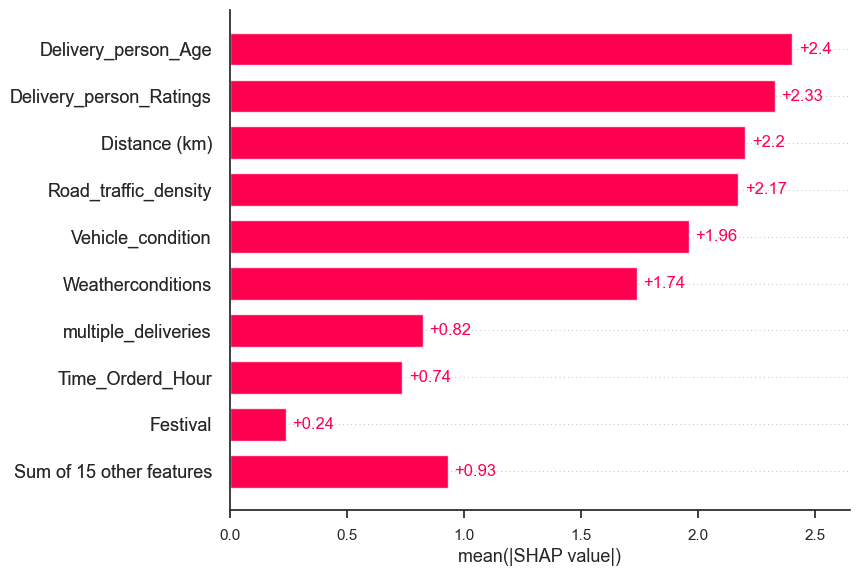

In [184]:

shap.plots.bar(shap_values)


plt.show()

## Conclusion
In conclusion, this project on time delivery prediction has been marked by significant achievements in algorithmic development and optimization techniques. Through the adept utilization of various algorithms and optimization methods, I have successfully attained a Mean Absolute Error (MAE) accuracy of 2.99 minutes, a noteworthy achievement. 

Furthermore, through extensive analysis, feature engineering, and the use of SHAP library, I identified nine key factors that significantly influence time delivery prediction. These factors include the age and ratings of delivery personnel, distance, road traffic density, vehicle condition, weather conditions, multiple deliveries, and the time of order placement. Understanding and incorporating these factors into our predictive model enables more precise and nuanced delivery time estimates. 

## NEXT STEPS:
1. Transition the developed predictive model from a research and development phase to a production environment by building a deployment pipeline. Implement containerization using technologies like Docker and orchestration with platforms such as Kubernetes to streamline the deployment process. Additionally, integrate the model with real-time data streams and automate retraining workflows to ensure continuous model improvement and adaptation to evolving delivery dynamics.

2. Develop a Web-based Dashboard:
Create an intuitive web-based dashboard that provides insights into delivery time predictions and performance metrics. Incorporate interactive visualizations and customizable filters to facilitate data-driven decision-making and proactive management of delivery operations. 



## REFERENCES
Scikit-learn Documentation. (2021). Scikit-learn Documentation. Retrieved from https://scikit-learn.org/stable/documentation.html

Yellowbrick Documentation. (2021). Yellowbrick Documentation. Retrieved from https://www.scikit-yb.org/en/latest/

VanderPlas, J. (2016). Python Data Science Handbook: Essential Tools for Working with Data. O'Reilly Media

Raschka, S., & Mirjalili, V. (2019). Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2. Packt Publishing.